In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import scipy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.externals import joblib 
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

Just to get the general sense of cluster data counts. +ve and -ve split for US companies. Positive count is twice the negative count 

In [4]:
us_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/us_data_cluster_predictions.csv')
us_data['cloud_flag'].value_counts()

1.0    1519
0.0     762
Name: cloud_flag, dtype: int64

Cluster performance split by cloud flag. Note that cluster 100 corrseponds to the companies that have cloud flag 0 and were not part of any of the 'cloud' clusters 

In [5]:
us_cluster_by_cloudFlag = pd.DataFrame(us_data.groupby(['cloud_flag', 'cluster']).agg(cluster_count=('cluster', 'count'),
                                                                                      median_distance = ('distance', np.median)))
us_cluster_by_cloudFlag

cluster_count  median_distance
cloud_flag cluster                                
0.0        0.0                 60          0.54615
           1.0                  8          0.68900
           2.0                113          0.57900
           3.0                 19          0.71400
           4.0                  2          2.39650
           100.0              560              NaN
1.0        0.0                753          1.64200
           1.0                126          4.68950
           2.0                379          4.13300
           3.0                178          4.11700
           4.0                 82          7.02550
           5.0                  1         56.03000

In [6]:
# Filtering for cloud flag = 1
cluster_flag1 = us_cluster_by_cloudFlag[us_cluster_by_cloudFlag.index.get_level_values(0) == 1]
cluster_flag1

cluster_count  median_distance
cloud_flag cluster                                
1.0        0.0                753           1.6420
           1.0                126           4.6895
           2.0                379           4.1330
           3.0                178           4.1170
           4.0                 82           7.0255
           5.0                  1          56.0300

In [7]:
# Cluster prediction for holdout data
result = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/results.csv') 
result = result[result['cluster'] <= 5]
result = result.groupby('cluster')['cloud_flag'].agg(total_count = 'count',
                                            percent_TP = lambda x: round(100*x.mean(),2))
result

,total_count,percent_TP
cluster,,
0,32,81.25
1,5,100.00
2,18,44.44
3,11,72.73
4,5,100.00


In [9]:
cluster_performance = pd.merge(result, cluster_flag1['median_distance'], how='inner', left_index=True, right_index=True )
cluster_performance.index = cluster_performance.index.droplevel()
cluster_performance

,total_count,percent_TP,median_distance
cluster,,,
0,32,81.25,1.6420
1,5,100.00,4.6895
2,18,44.44,4.1330
3,11,72.73,4.1170
4,5,100.00,7.0255


From the cluster properties- 
4 appears to be spread out quite a lot.
0 and 1 looks compact  

Cluster Analysis:
Try to inspect the feature distrbution across clusters - 0,1,2,3,4. We will compare this with values from cluster 100(flagged as companies who dont have a propensity for cloud migration) and try to extract any behavior/patterns

Secondly, we will compare the values for all positive class companies(coud_flag =1) with cluster 100 companies. 

Based on the above two, we will try to describe the comanies in the best way in terms of features 

##### Chart: Data Frame to keep track of the column aggregate values clusterwise
##### To append values for a particular column, create a bar plot of the column()using the plot_bar function). 
##### 'Chart' will be updated with the values for the clusters specified

In [0]:
chart = pd.DataFrame(columns=['Aggregation',0,1,2,3,4,100,'Cloud'], index=us_data.columns.values)

## Functions to plot histogram and bar charts

In [0]:
def plot_histogram(df, column_name, cluster_list=[], cluster_split=True, size=(10,8), kde=True):
    """
    Summary  : Function to plot the histogram of a column in the dataframe specified
    Arguments: 
        df: dataframe to be used
        column_name : Column name in 'df' for which the histogram, has to be plotted
        cluster_list : List of clusters to be included 
        cluster_split : If true, A different histogram for each cluster will be created in a single figure
                        If false, create 2 histograms :
                            1. all clusters except 100 are selected (representative of overall cloud behavior)
                            2. cluster 100 (representative of overall non-cloud behavior)
    """
    plt.figure(figsize=size)
    if cluster_split:
        for cluster in cluster_list:
            if cluster==100:
                temp = df[(df['cluster']==cluster) & (df['cloud_flag']==0)]
            else:
                temp = df[(df['cluster']==cluster) & (df['cloud_flag']==1)]            
            sns.kdeplot(temp[column_name], label = 'Cluster '+str(cluster), shade=True)
    else:
         sns.kdeplot(df.loc[df['cloud_flag']==1, column_name], shade=True, label='Cloud')
         clust_100 = df[(df['cluster']==100) & (df['cloud_flag']==0)]   
         sns.kdeplot(clust_100[column_name], shade=True, label='Non-Cloud')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.title('Distribution of ' + column_name)


def plot_bar(df, column_name, cluster_list=[], cluster_split=True, aggr='median'):
    """
    Summary  : Function to create the barplot of a column in the dataframe specified
    Arguments: 
        df: dataframe to be used
        column_name : Column name in 'df' for which the bar chart has to be plotted
        cluster_list : List of clusters to be included 
        cluster_split : If true, A bar for each cluster will be created in a single figure
                        If false, create 2 bars :
                            1. all clusters except 100 are selected (representative of overall cloud behavior)
                            2. cluster 100 (representative of overall non-cloud behavior)
    """
    if cluster_split:
        df_filter = df[df['cluster'].apply(lambda x: x in cluster_list)]
        plt.figure(figsize=(10,8))
        total = df_filter.groupby('cluster')[column_name].agg(aggr)
        total = total.reindex(total.index.astype(int))
        sns.barplot(total.index, total.values)
        plt.xlabel('Cluster')
        plt.ylabel(aggr + ' ' + column_name)
        chart.loc[column_name, total.index] = total.values

    else:
        plt.figure(figsize=(4,6))
        total_cloud = us_data.groupby('cloud_flag')[column_name].agg(aggr)
        total_cloud = total_cloud[total_cloud.index==1.0].values
        chart.loc[column_name, 'Cloud'] = total_cloud[0]
        total_clust100 = us_data[us_data['cluster'] == 100][column_name].apply(aggr)
        total = pd.Series([total_cloud[0], total_clust100], index=['Cloud', 'Non-Cloud'])
        sns.barplot(total.index, total.values)
        plt.ylabel(aggr + ' ' + column_name)

        chart.loc[column_name, 'Aggregation'] = aggr

cluster_list = [0,1,2,3,4,100]  #not including the outlier companies in cluster 5
clusterList_filter = [0,1,2,3,100]

### Internal Total

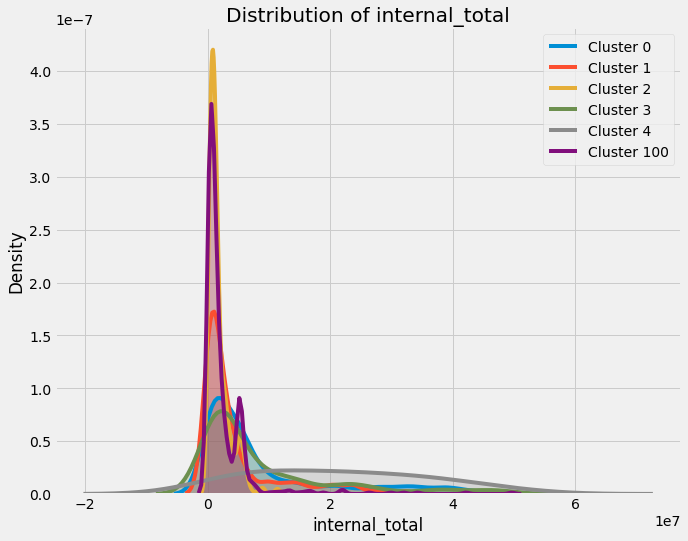

In [16]:
df_filter = us_data[us_data['internal_total']<50000000]
plot_histogram(df_filter, 'internal_total', cluster_list)

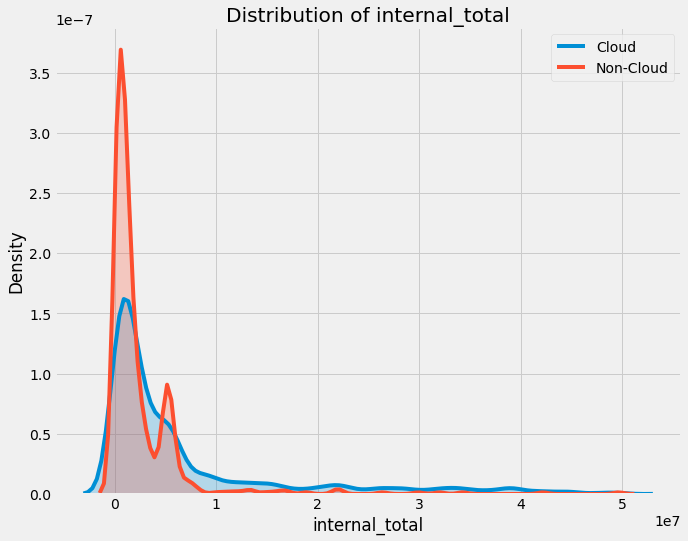

In [17]:
plot_histogram(df_filter, 'internal_total', cluster_split=False)

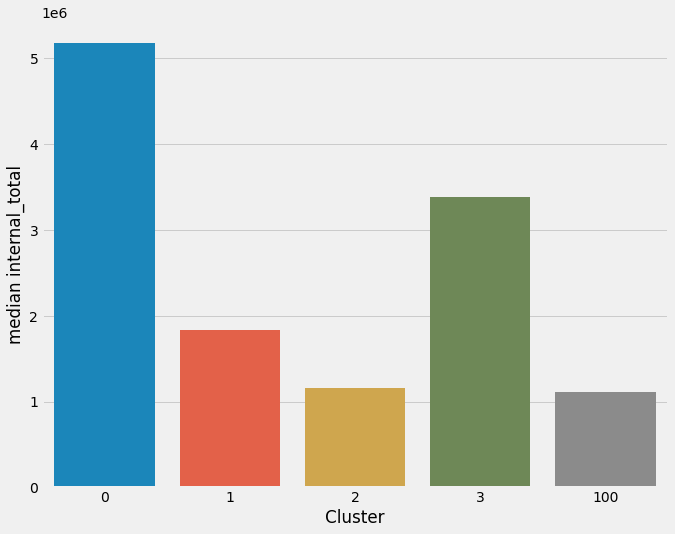

In [18]:
plot_bar(us_data, 'internal_total', cluster_list=clusterList_filter, aggr='median')

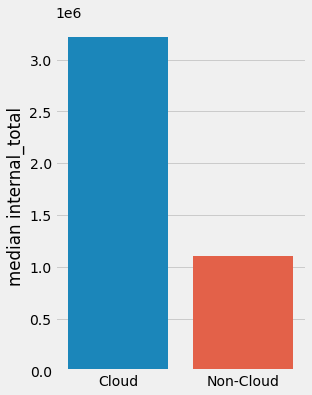

In [19]:
plot_bar(us_data, 'internal_total', cluster_split=False, aggr='median')

## External vs Internal

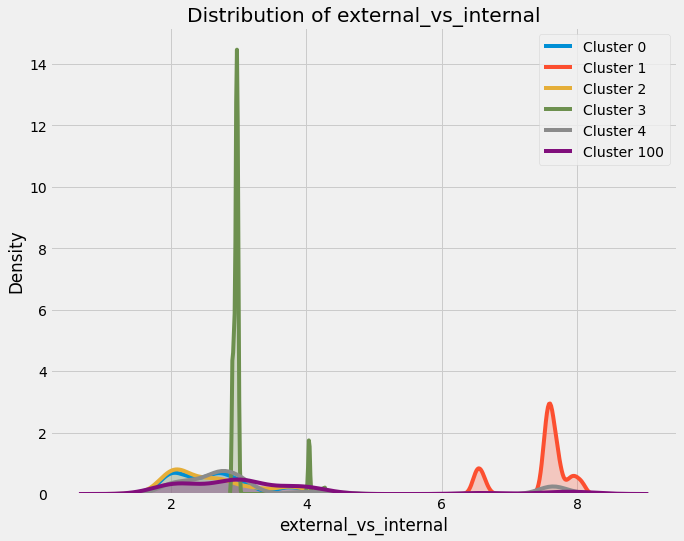

In [20]:
plot_histogram(us_data, 'external_vs_internal', cluster_list=cluster_list)

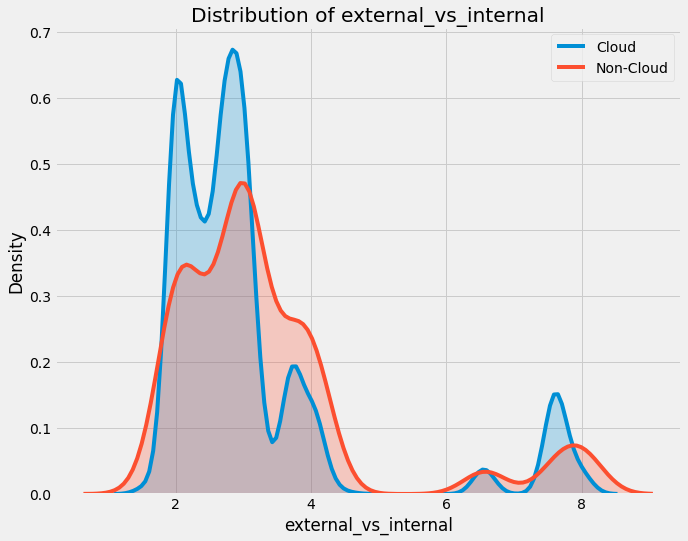

In [21]:
plot_histogram(us_data, 'external_vs_internal', cluster_split=False)

## Total Employees

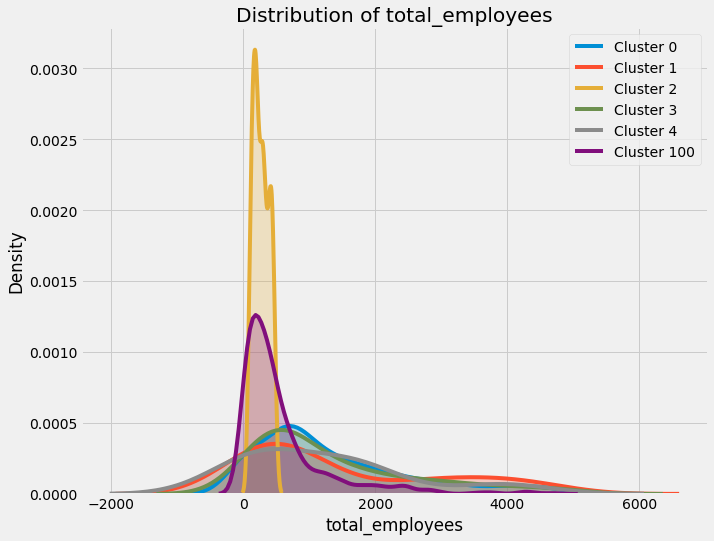

In [22]:
df_filter = us_data[us_data['total_employees'] < 5000]
plot_histogram(df_filter, 'total_employees', cluster_list=cluster_list)

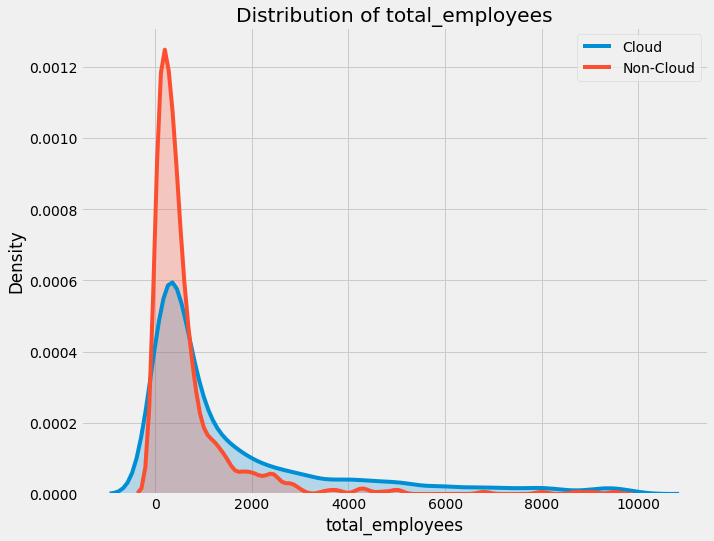

In [23]:
df_filter = us_data[us_data['total_employees'] < 10000]
plot_histogram(df_filter, 'total_employees', cluster_split=False)

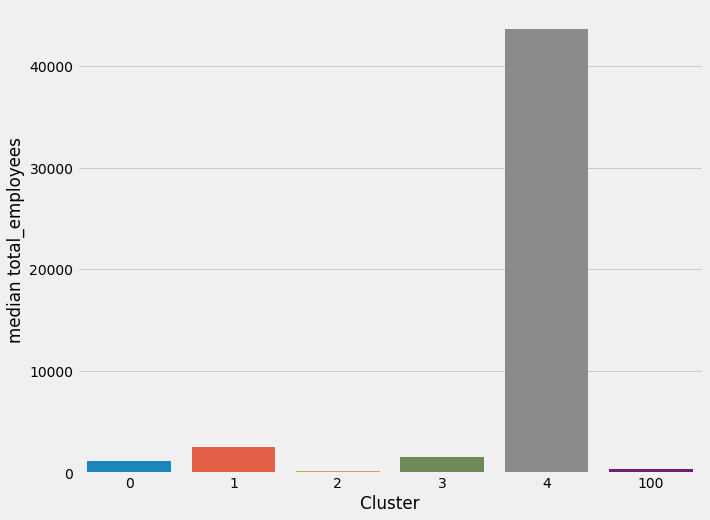

In [24]:
plot_bar(us_data, 'total_employees', cluster_list)

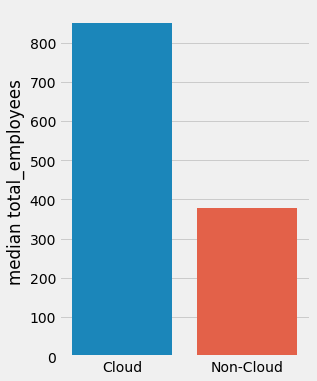

In [25]:
plot_bar(us_data, 'total_employees', cluster_split=False)

## Total 200 features

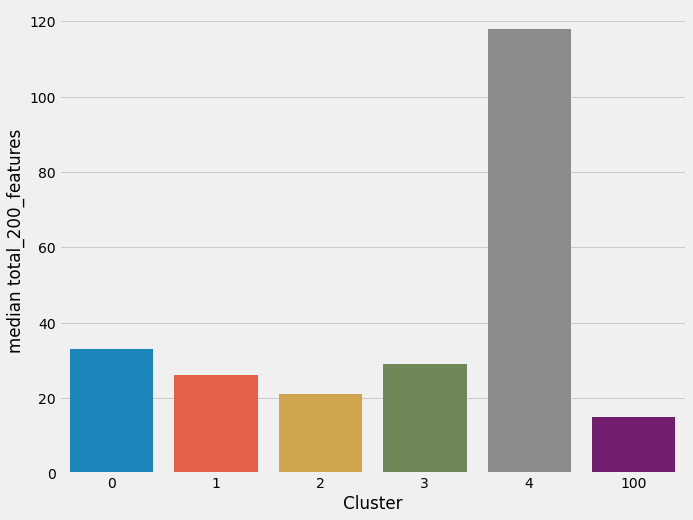

In [26]:
plot_bar(us_data, 'total_200_features', cluster_list=cluster_list)

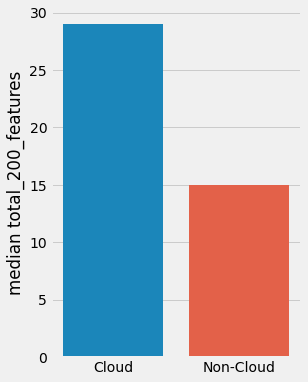

In [27]:
plot_bar(us_data, 'total_200_features', cluster_split=False)

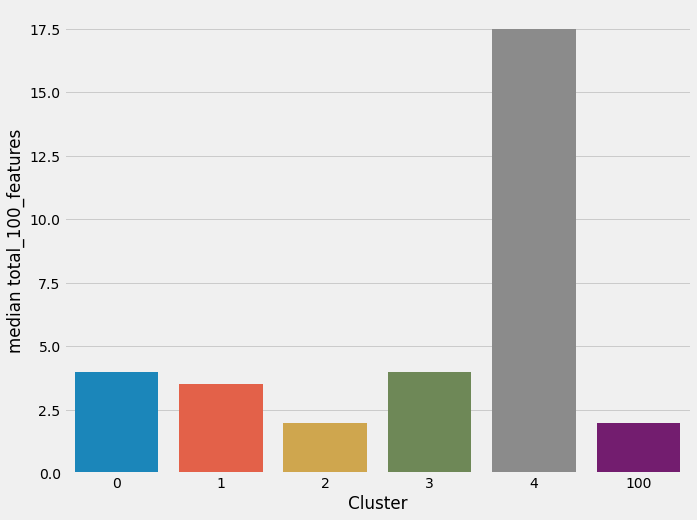

In [28]:
plot_bar(us_data, 'total_100_features', cluster_list=cluster_list)

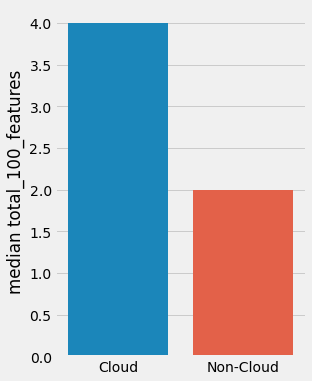

In [29]:
plot_bar(us_data, 'total_100_features', cluster_split=False)

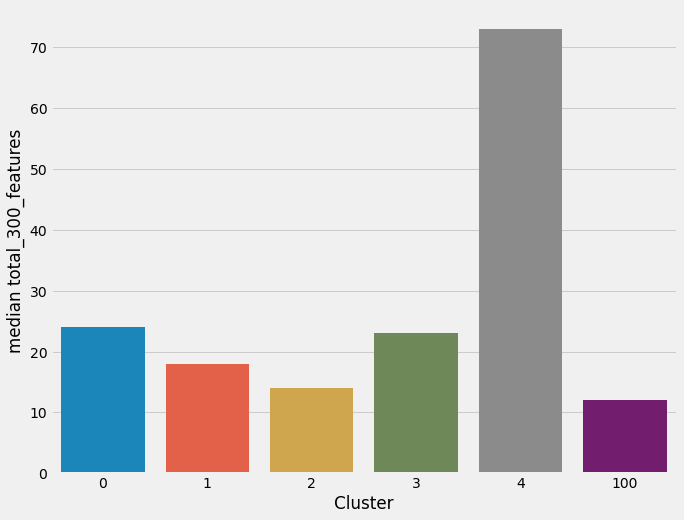

In [30]:
plot_bar(us_data, 'total_300_features', cluster_list=cluster_list)

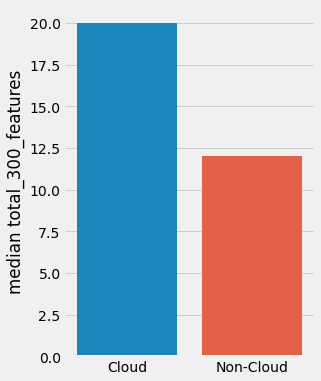

In [31]:
plot_bar(us_data, 'total_300_features', cluster_split=False)

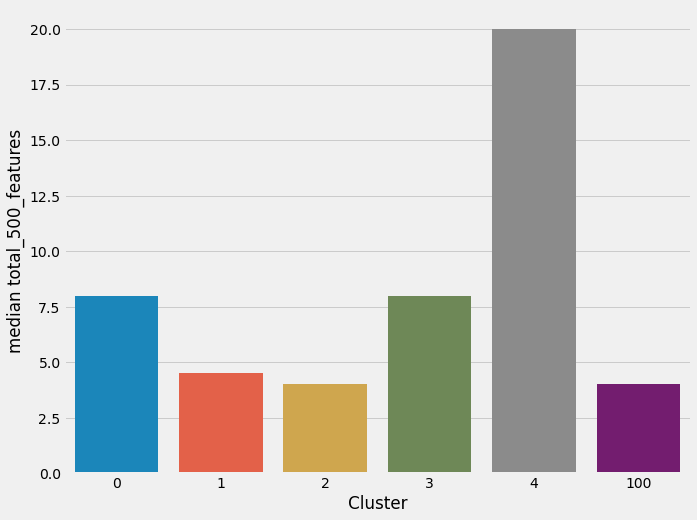

In [32]:
plot_bar(us_data, 'total_500_features', cluster_list=cluster_list)

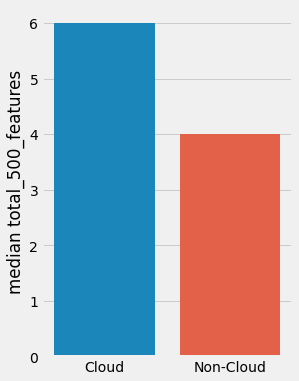

In [33]:
plot_bar(us_data, 'total_500_features', cluster_split=False)

## Per feature 307

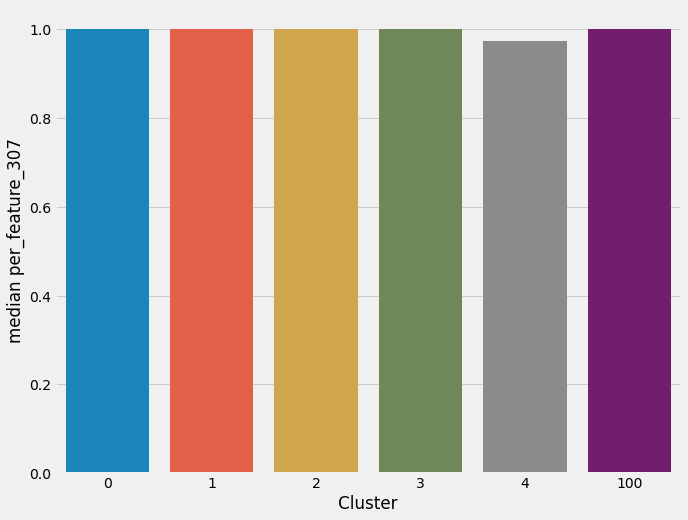

In [34]:
plot_bar(us_data, 'per_feature_307', cluster_list=cluster_list)

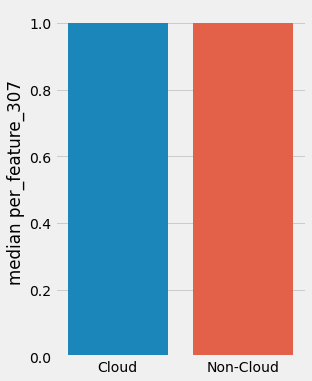

In [35]:
plot_bar(us_data, 'per_feature_307', cluster_split=False)

## Emp Bands

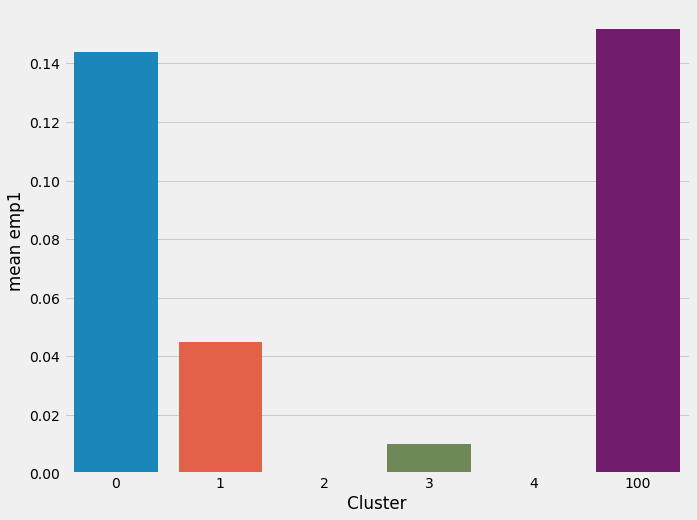

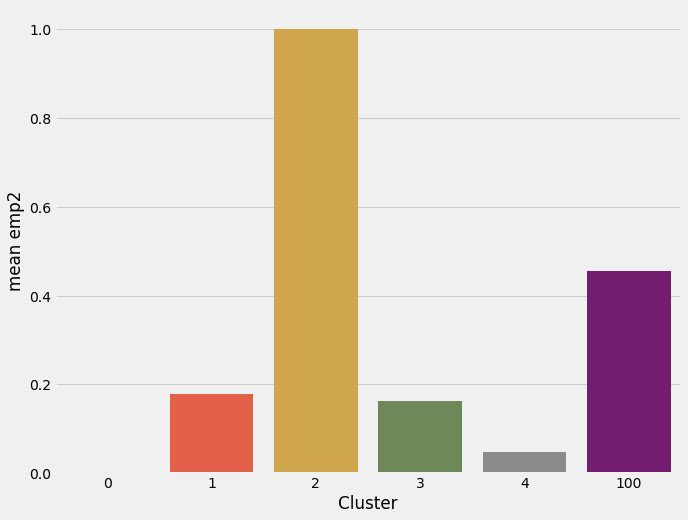

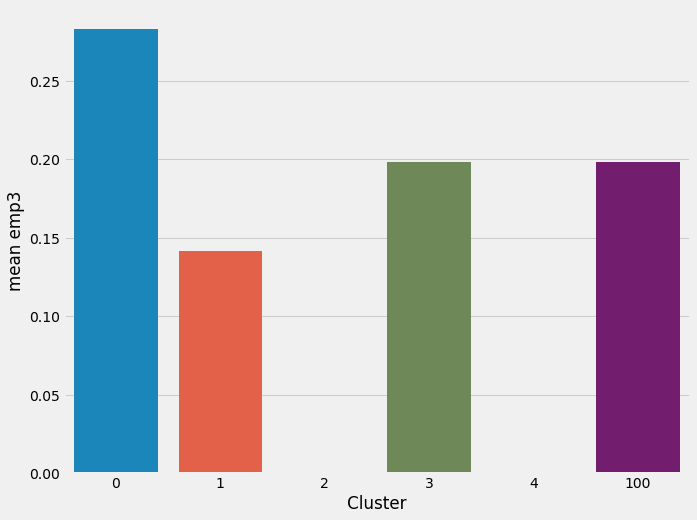

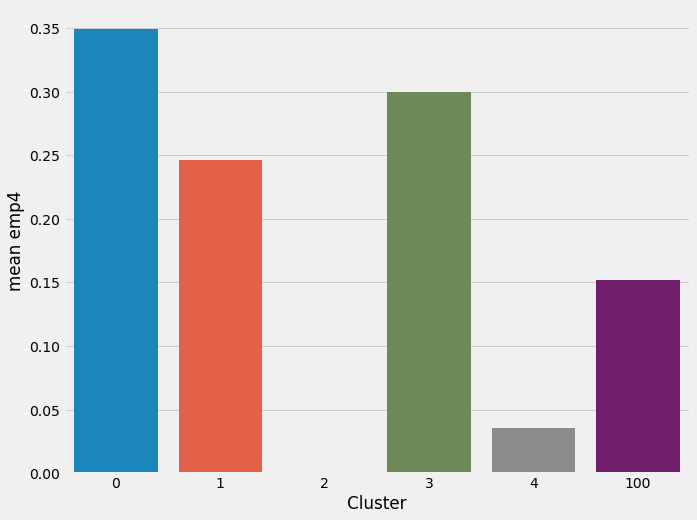

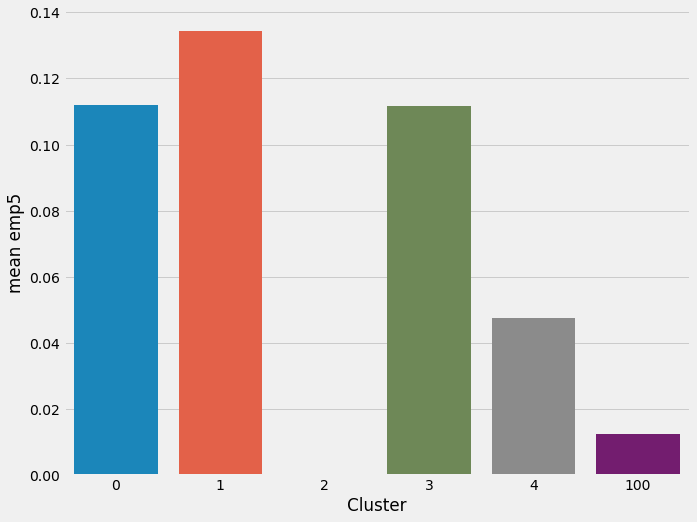

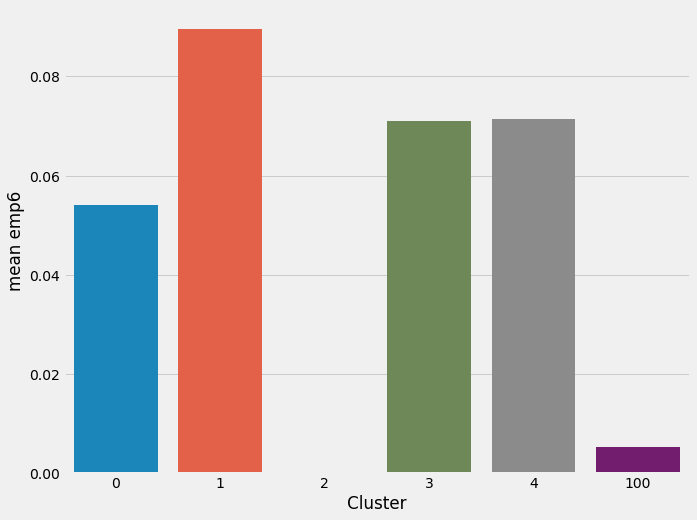

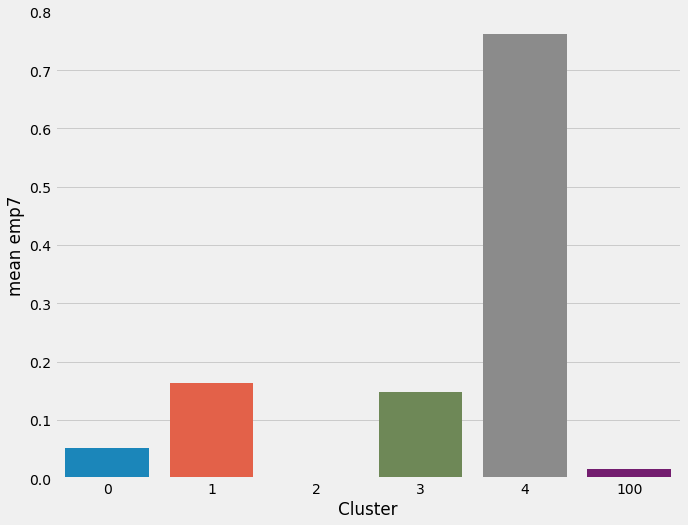

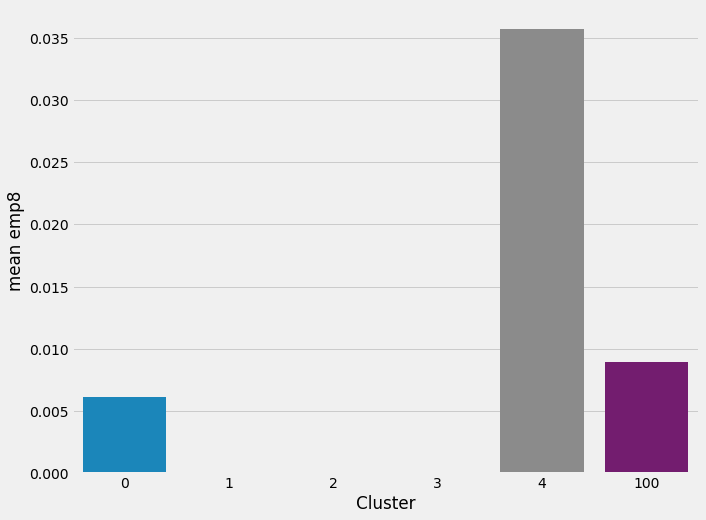

In [36]:
for emp_band in ['emp1', 'emp2', 'emp3', 'emp4', 'emp5', 'emp6', 'emp7', 'emp8']:
    plot_bar(us_data, emp_band, cluster_list=cluster_list, aggr='mean')

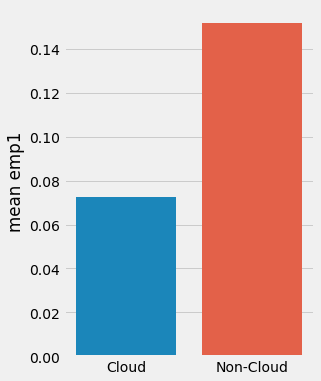

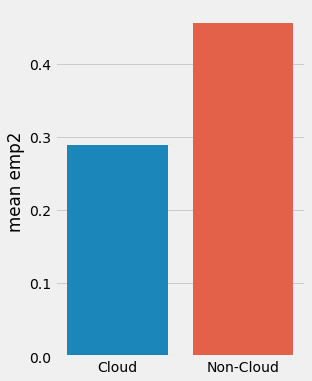

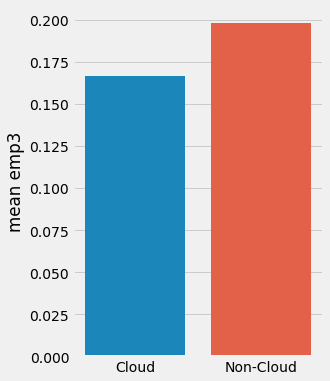

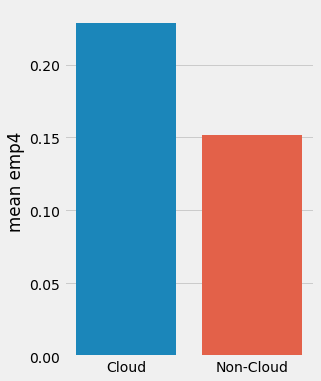

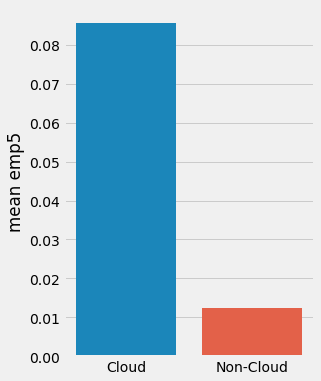

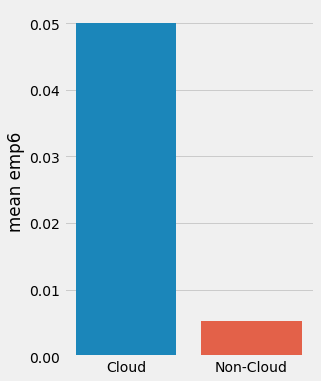

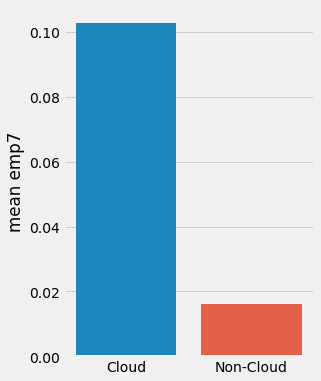

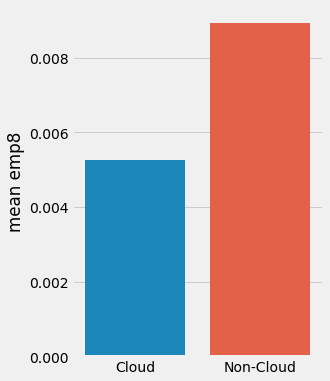

In [37]:
for emp_band in ['emp1', 'emp2', 'emp3', 'emp4', 'emp5', 'emp6', 'emp7', 'emp8']:
    plot_bar(us_data, emp_band, cluster_split=False, aggr='mean')

## Capacity

#### 1. Raw capacity 

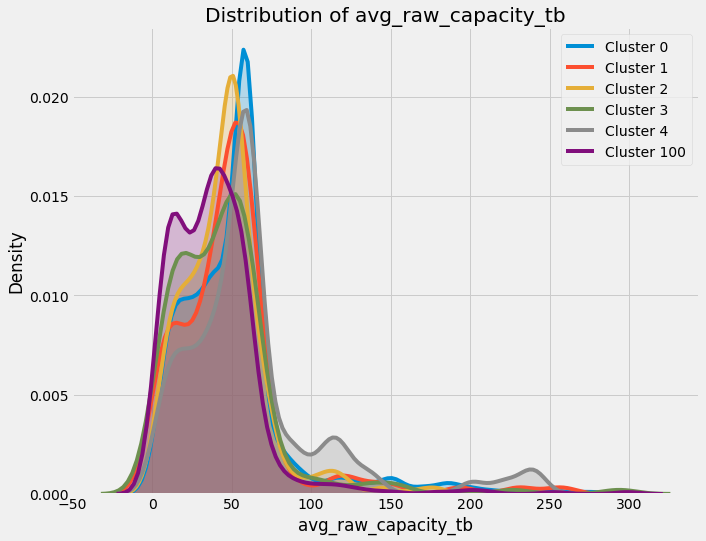

In [38]:
df_filter = us_data[us_data['avg_raw_capacity_tb'] < 300]
plot_histogram(df_filter, 'avg_raw_capacity_tb', cluster_list=cluster_list)

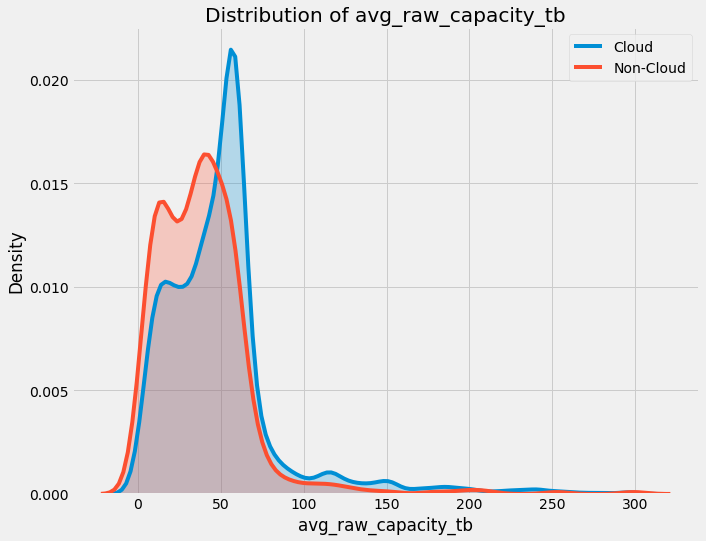

In [39]:
plot_histogram(df_filter, 'avg_raw_capacity_tb', cluster_split=False)

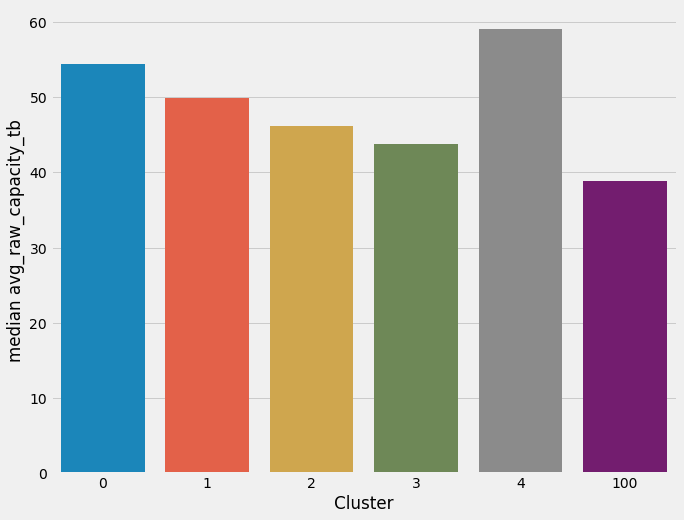

In [40]:
plot_bar(us_data, 'avg_raw_capacity_tb', cluster_list)

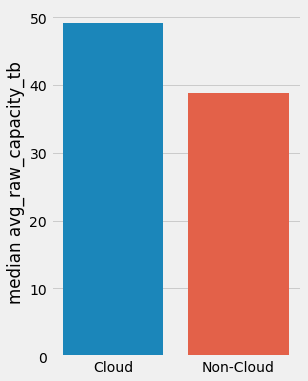

In [41]:
plot_bar(us_data, 'avg_raw_capacity_tb', cluster_split=False)

#### 2. Usable capacity

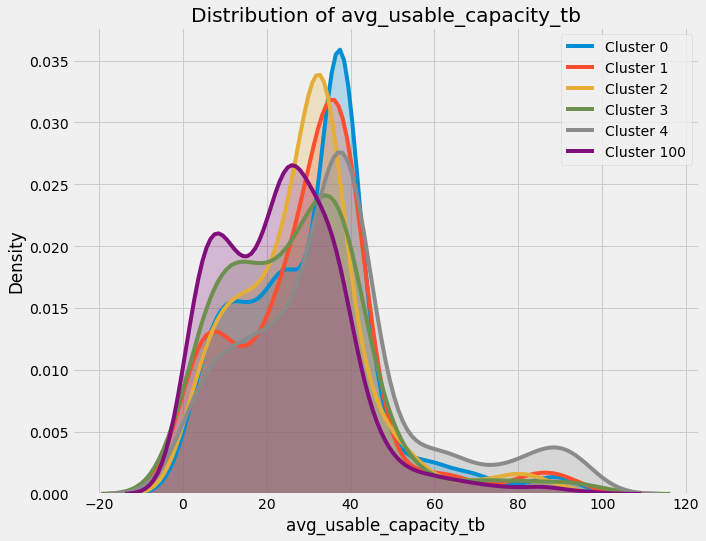

In [42]:
df_filter = us_data[us_data['avg_usable_capacity_tb'] < 100]
plot_histogram(df_filter, 'avg_usable_capacity_tb', cluster_list=cluster_list)

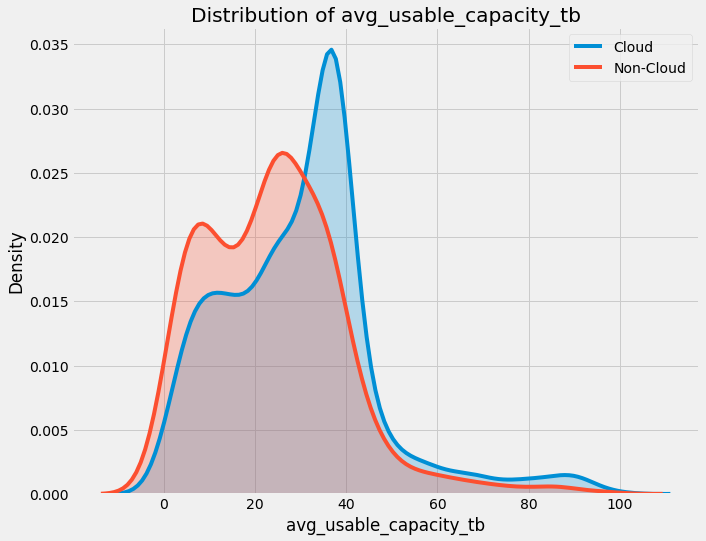

In [43]:
plot_histogram(df_filter, 'avg_usable_capacity_tb', cluster_split=False)

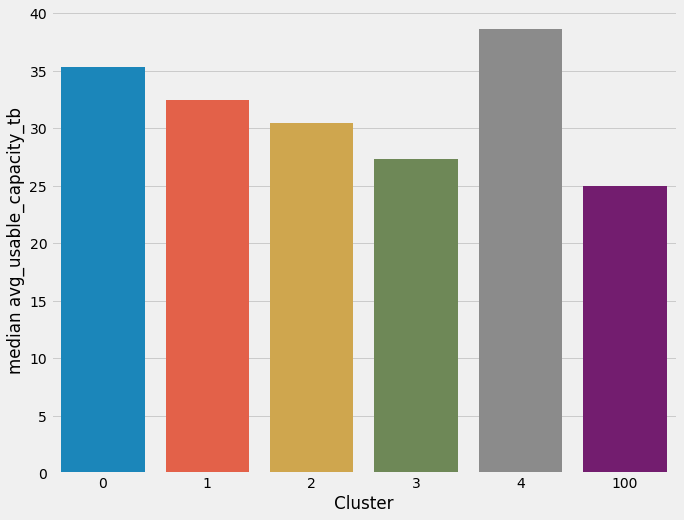

In [44]:
plot_bar(us_data, 'avg_usable_capacity_tb', cluster_list=cluster_list)

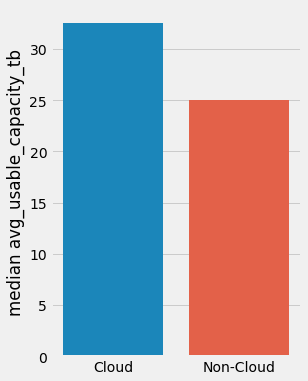

In [45]:
plot_bar(us_data, 'avg_usable_capacity_tb', cluster_split=False)

#### 3. Free capacity

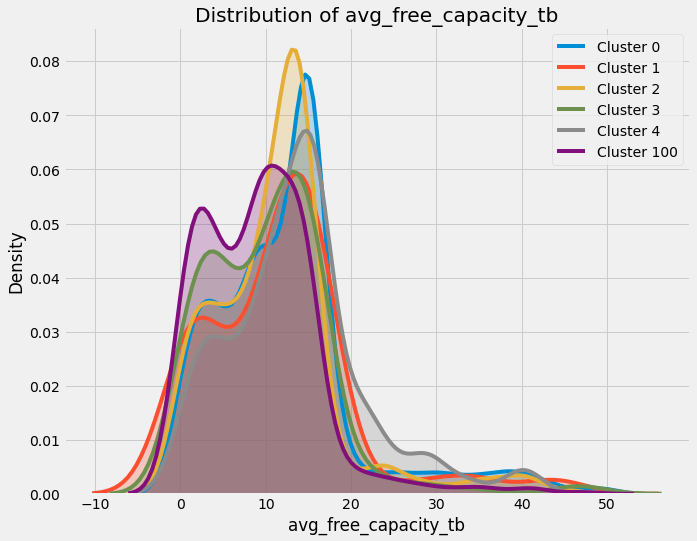

In [46]:
df_filter = us_data[us_data['avg_free_capacity_tb'] < 50]
plot_histogram(df_filter, 'avg_free_capacity_tb', cluster_list=cluster_list)

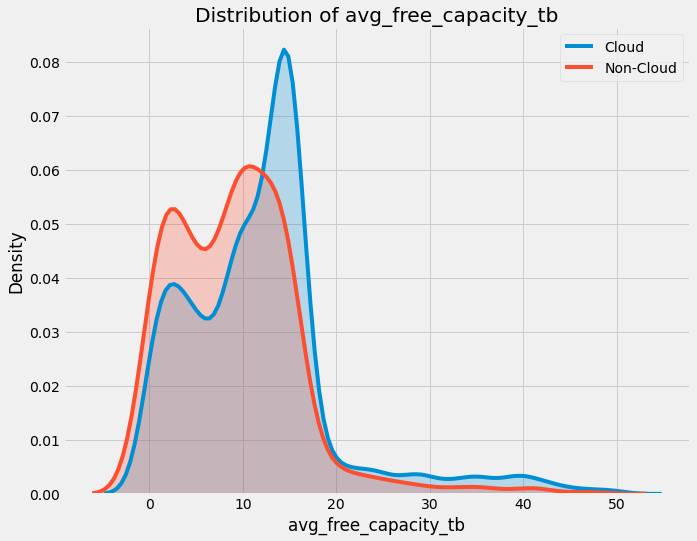

In [47]:
plot_histogram(df_filter, 'avg_free_capacity_tb', cluster_split=False)

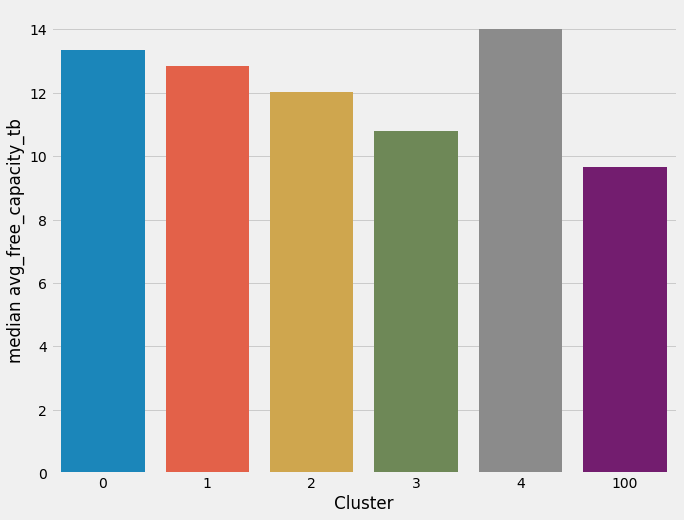

In [48]:
plot_bar(us_data, 'avg_free_capacity_tb', cluster_list=cluster_list)

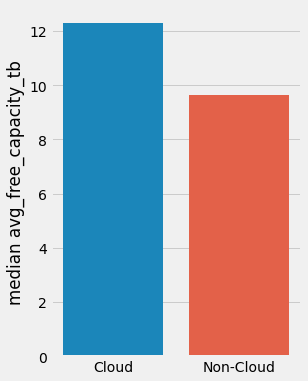

In [49]:
plot_bar(us_data, 'avg_free_capacity_tb', cluster_split=False)

#### 4.Used capacity

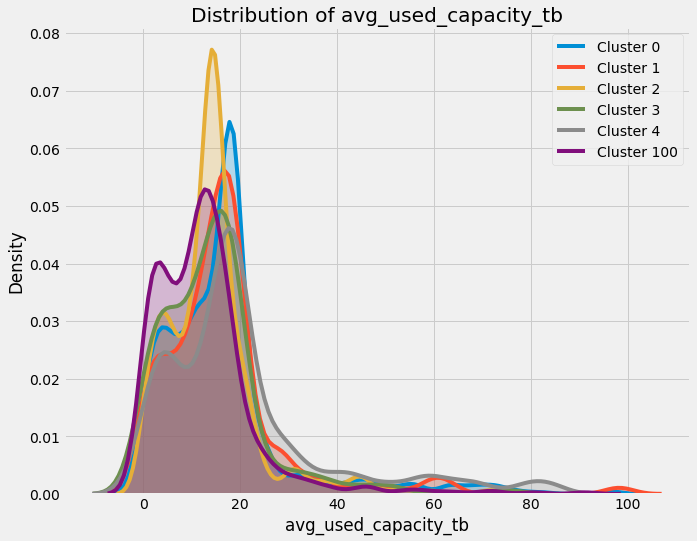

In [50]:
df_filter = us_data[us_data['avg_used_capacity_tb'] < 100]
plot_histogram(df_filter, 'avg_used_capacity_tb', cluster_list=cluster_list)

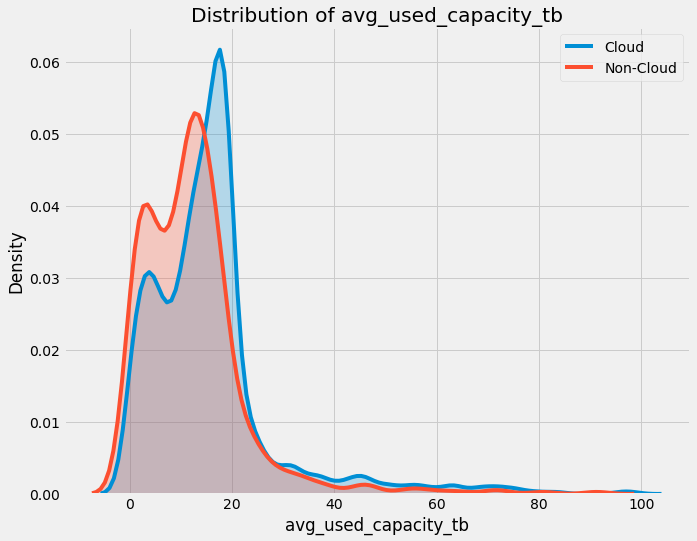

In [51]:
plot_histogram(df_filter, 'avg_used_capacity_tb', cluster_split=False)

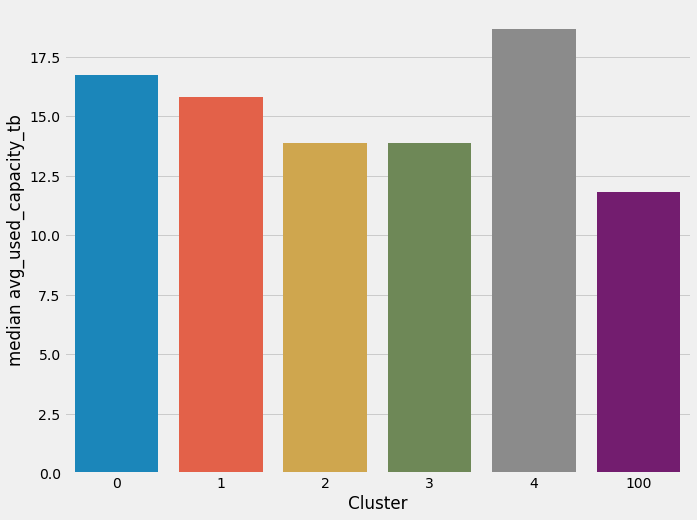

In [52]:
plot_bar(us_data, 'avg_used_capacity_tb', cluster_list=cluster_list)

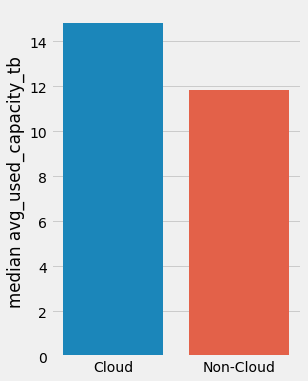

In [53]:
plot_bar(us_data, 'avg_used_capacity_tb', cluster_split=False)

#### 5. Storage spend

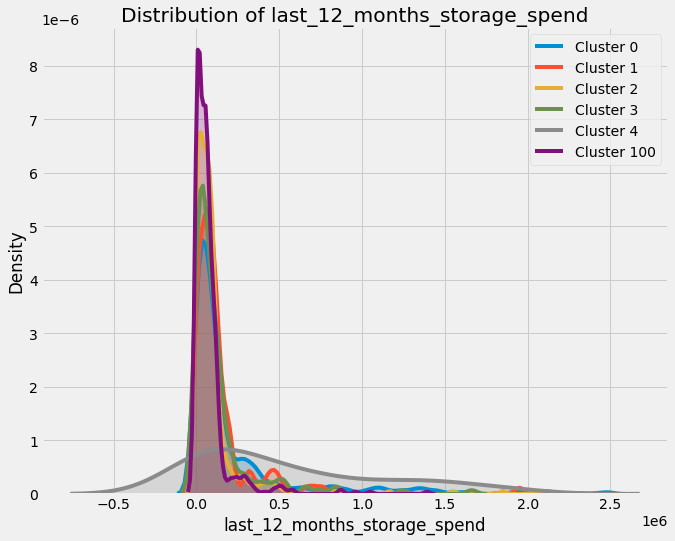

In [54]:
df_filter = us_data[us_data['last_12_months_storage_spend'] < 2500000]
plot_histogram(df_filter, 'last_12_months_storage_spend', cluster_list=cluster_list)

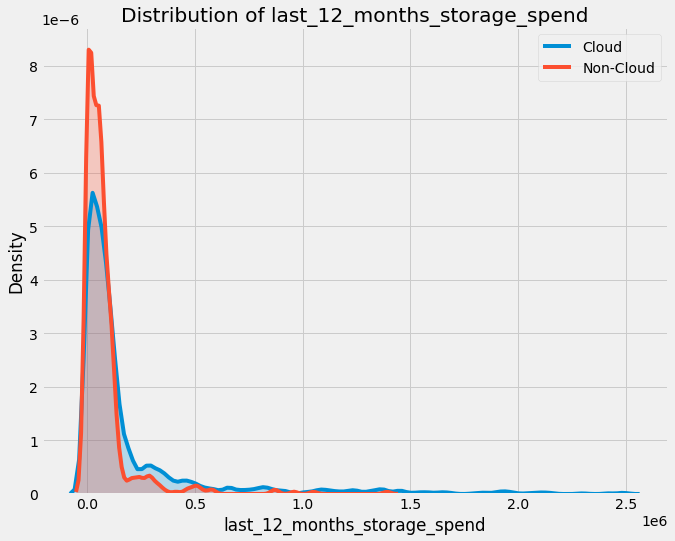

In [55]:
plot_histogram(df_filter, 'last_12_months_storage_spend', cluster_split=False)

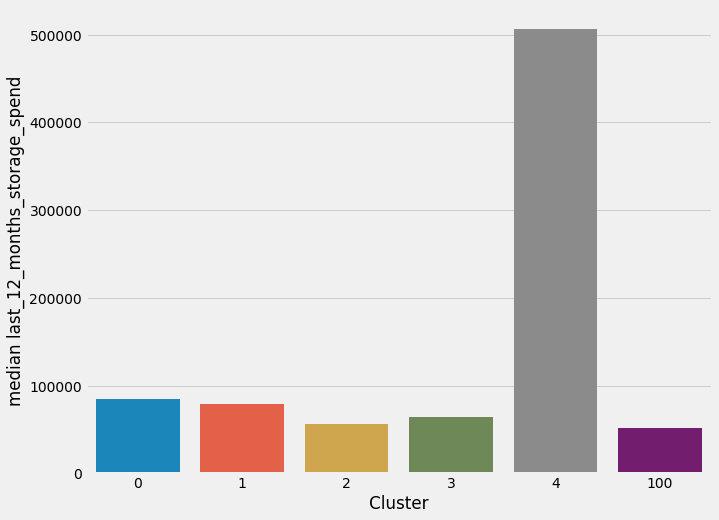

In [56]:
plot_bar(us_data, 'last_12_months_storage_spend', cluster_list=cluster_list, aggr='median')

Cluster 4 looks way off from others, Lets remove 4 and inspect the rest

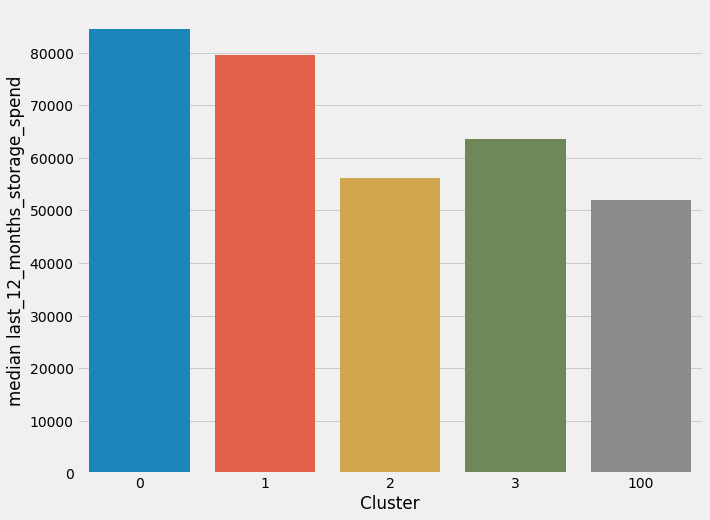

In [57]:
plot_bar(us_data, 'last_12_months_storage_spend', cluster_list=clusterList_filter, aggr='median')

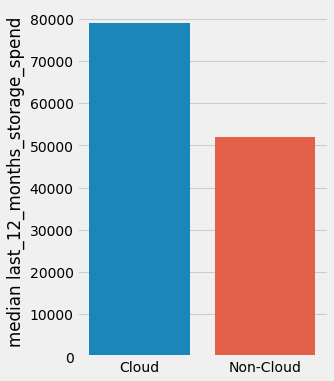

In [58]:
plot_bar(us_data, 'last_12_months_storage_spend', cluster_split=False, aggr='median')

#### 6. Capacity utilization

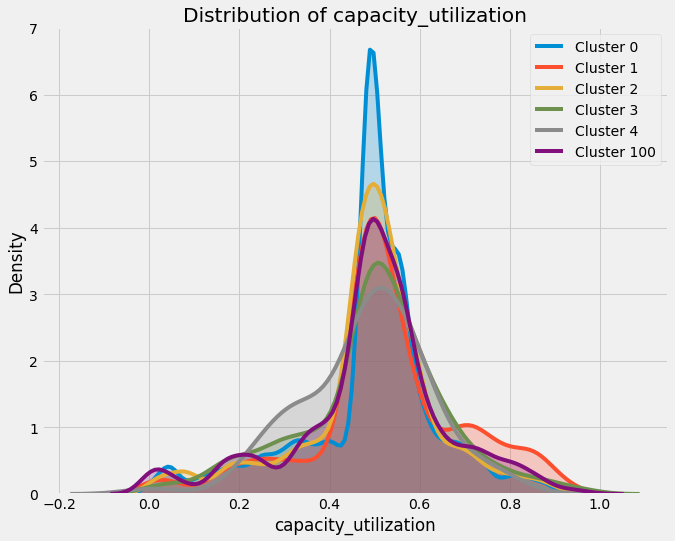

In [59]:
df_filter = us_data[us_data['capacity_utilization'] < 1000000000]
plot_histogram(df_filter, 'capacity_utilization', cluster_list=cluster_list)

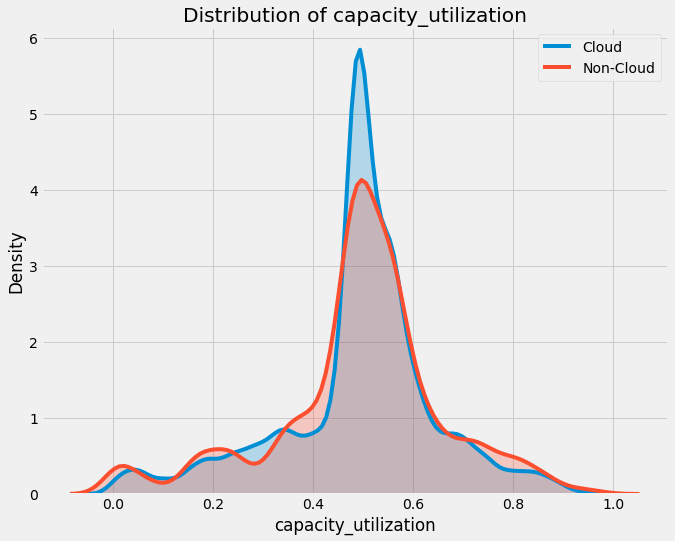

In [60]:
plot_histogram(df_filter, 'capacity_utilization', cluster_split=False)

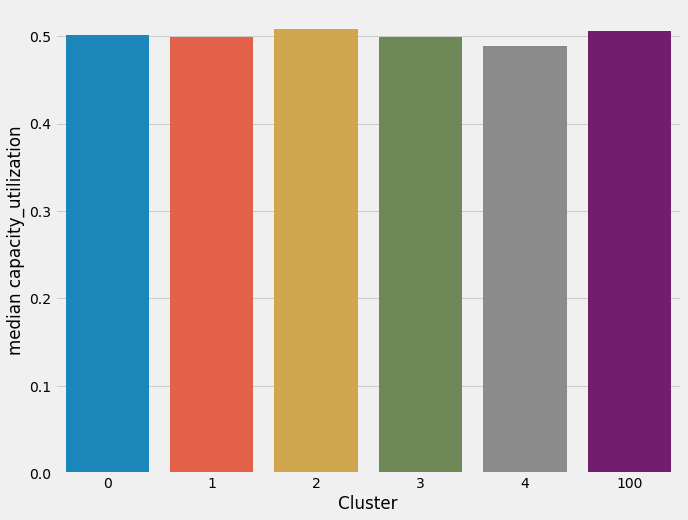

In [61]:
plot_bar(us_data, 'capacity_utilization', cluster_list=cluster_list, aggr='median')

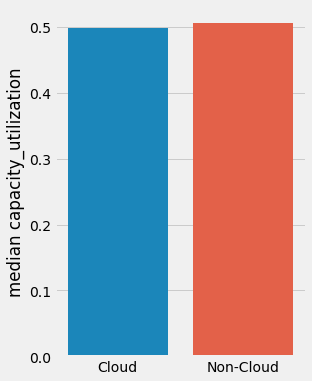

In [62]:
plot_bar(us_data, 'capacity_utilization', cluster_split=False)

## Products

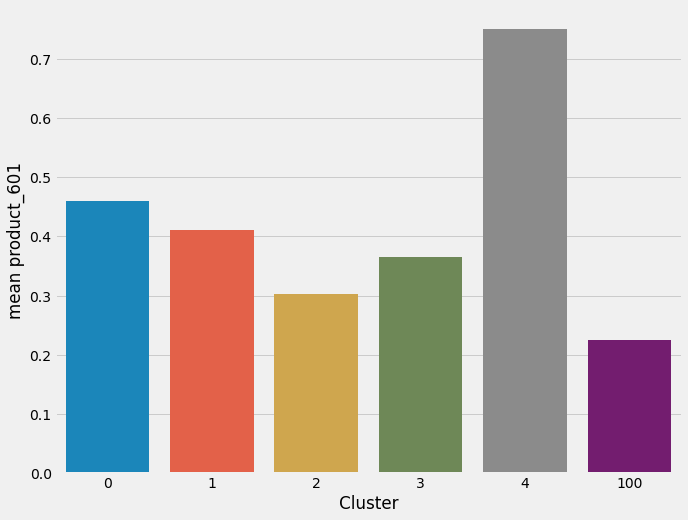

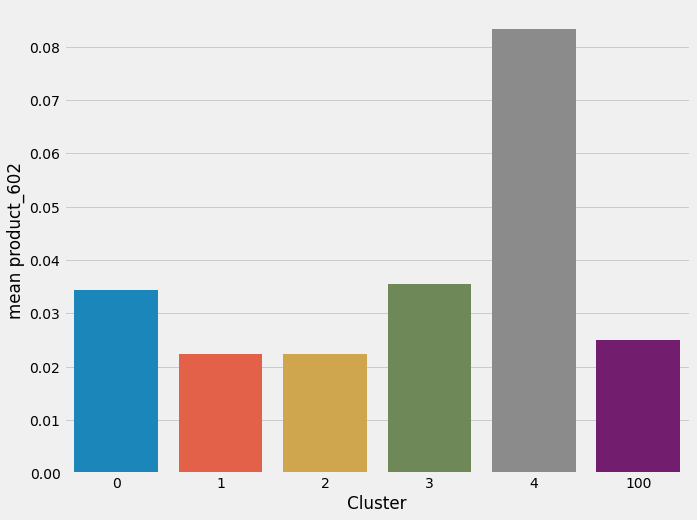

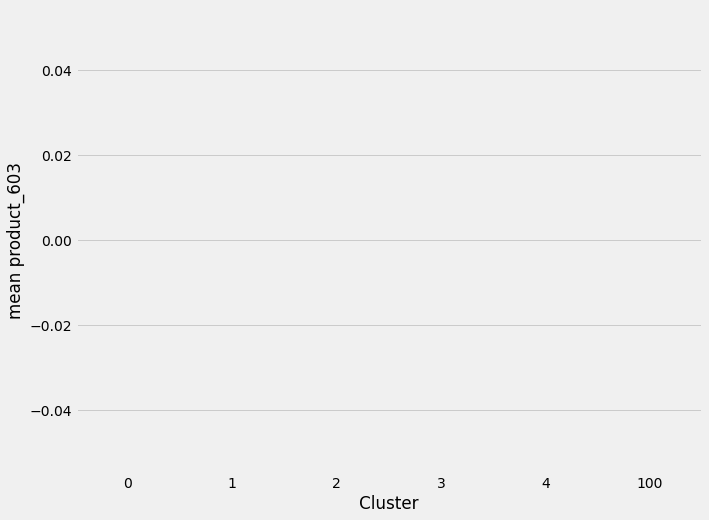

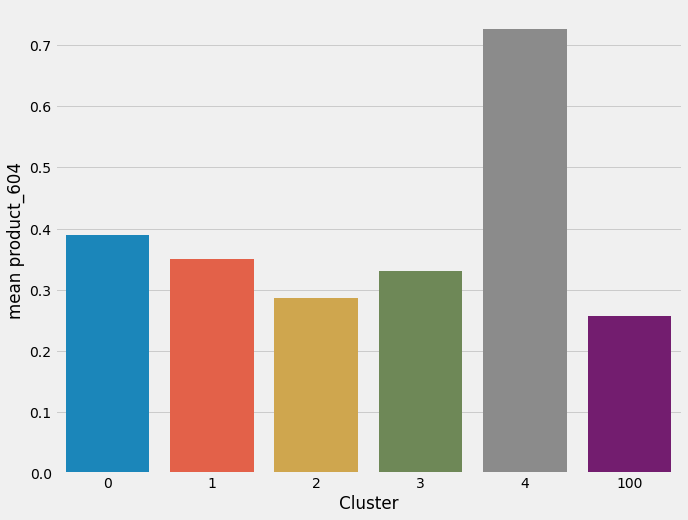

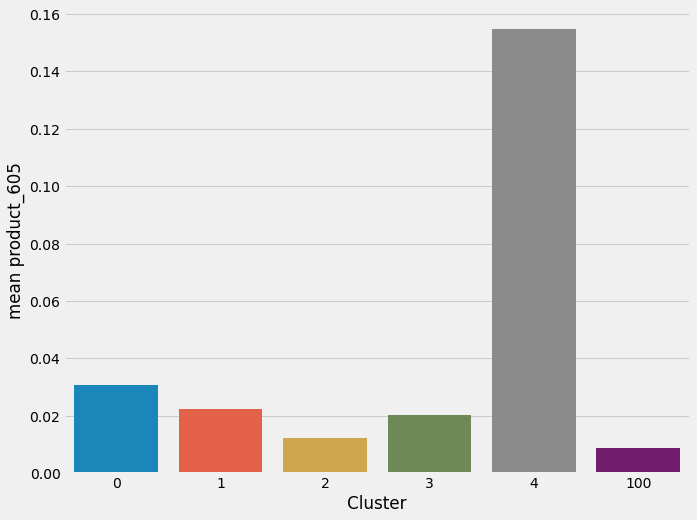

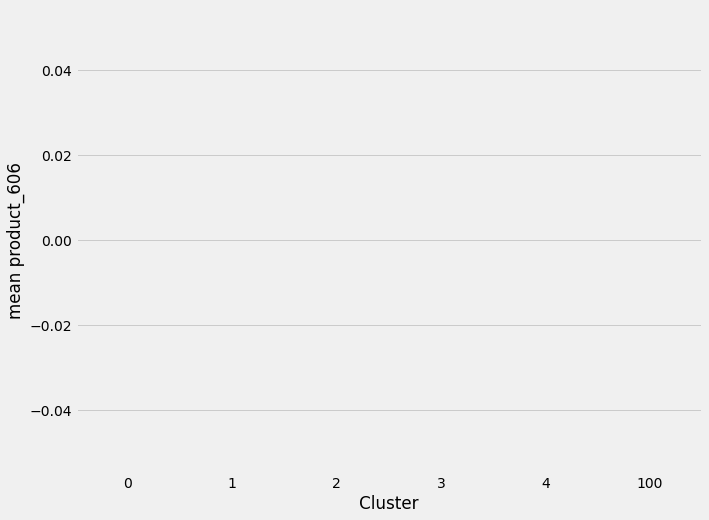

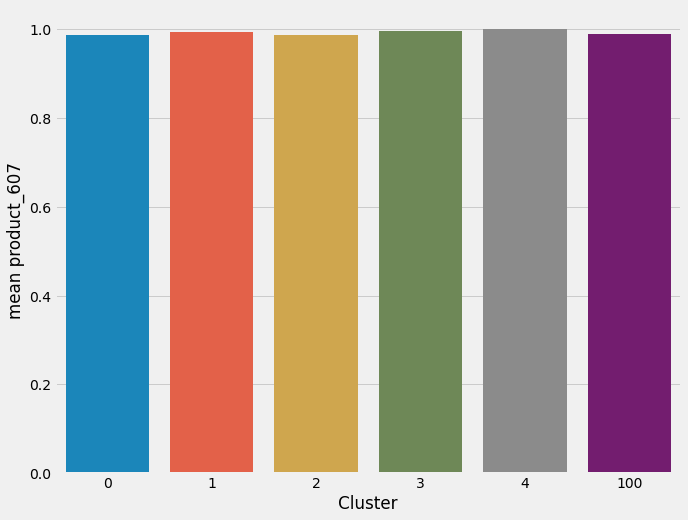

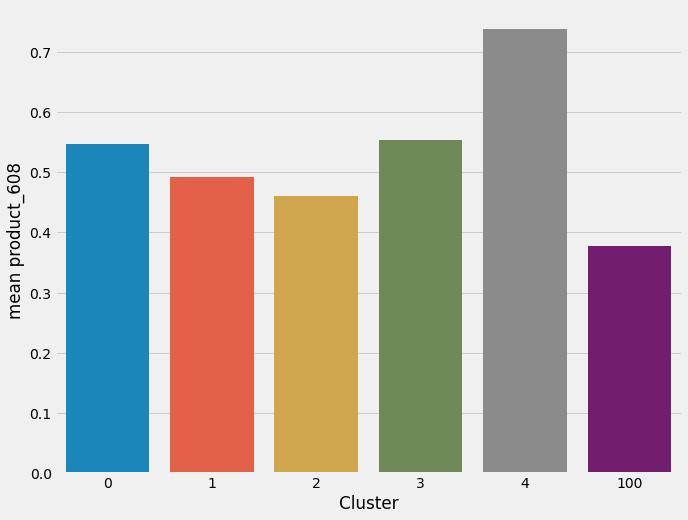

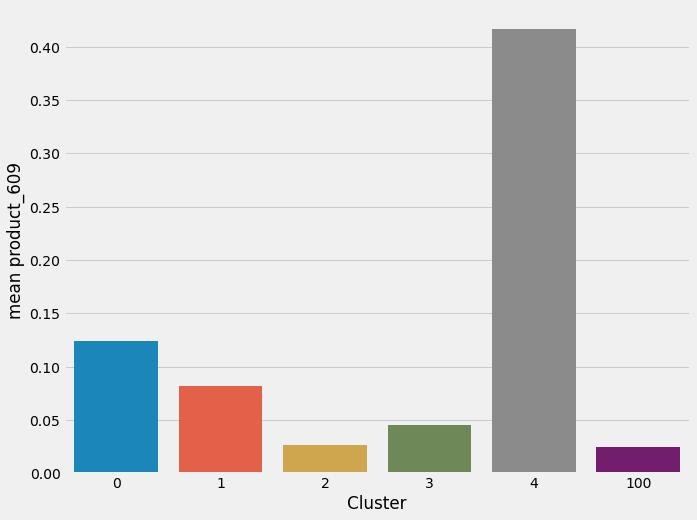

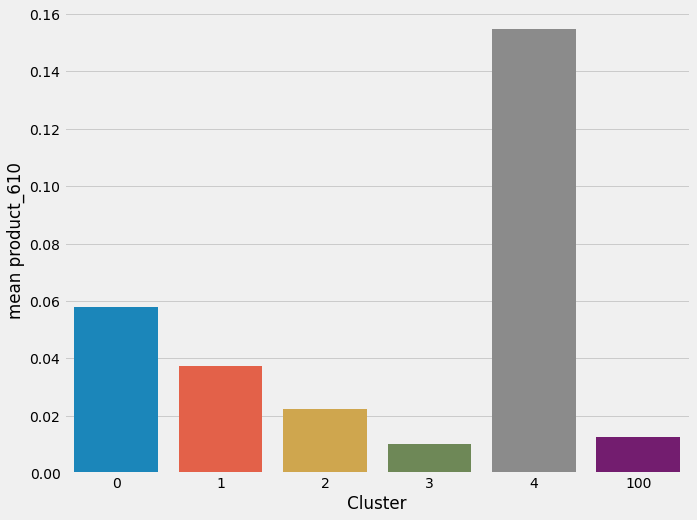

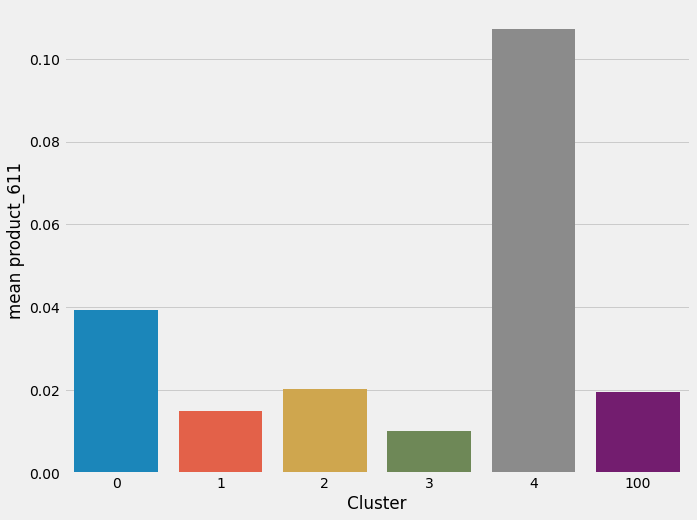

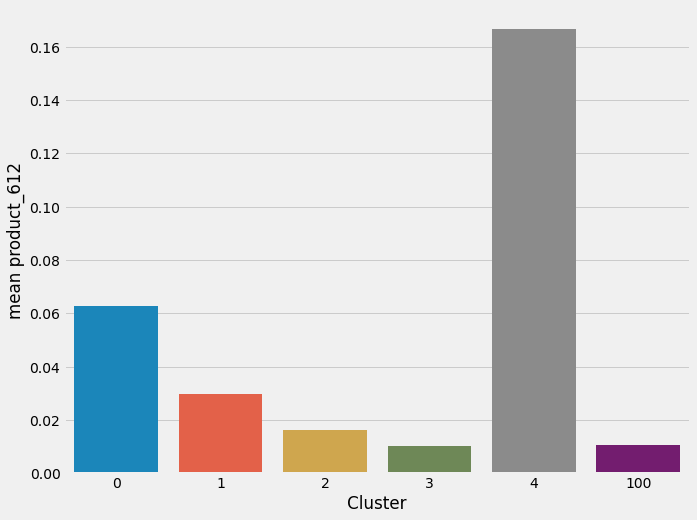

In [63]:
prod_list = ['product_'+str(n) for n in range(601, 613)]
for prod in prod_list:
    plot_bar(us_data, prod, cluster_list=cluster_list, aggr='mean')

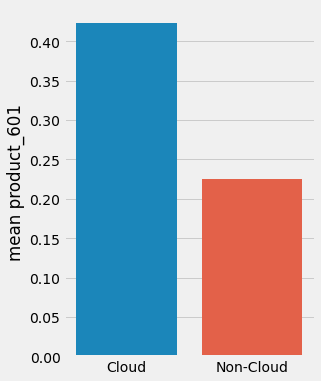

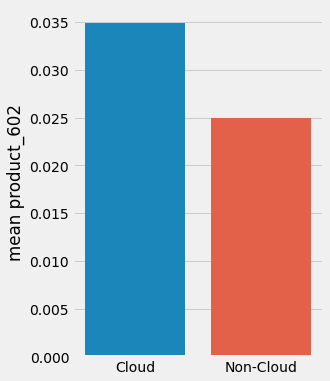

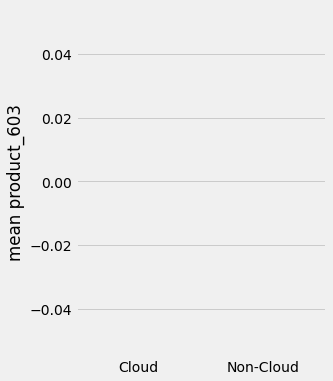

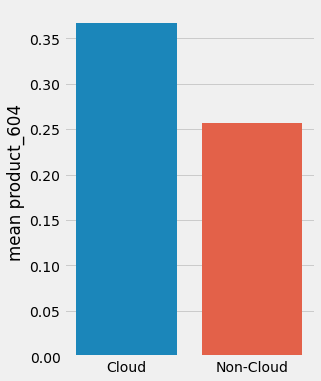

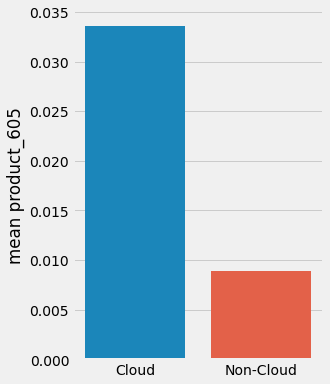

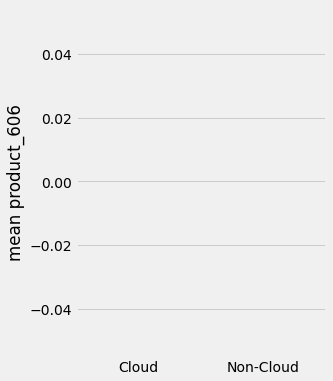

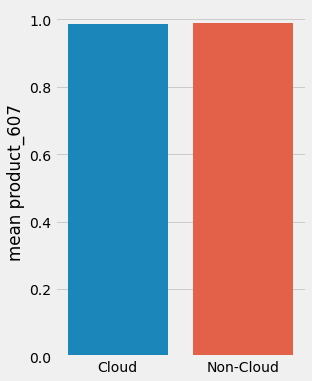

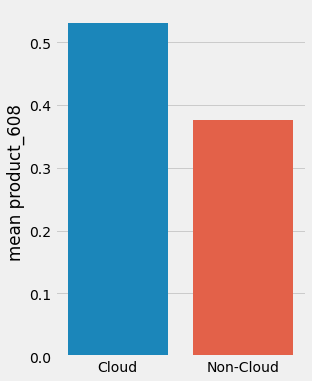

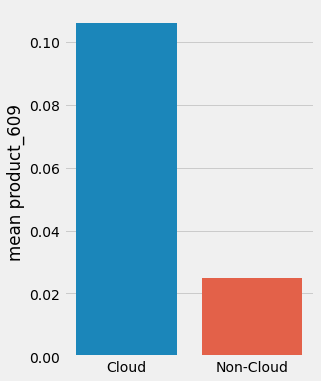

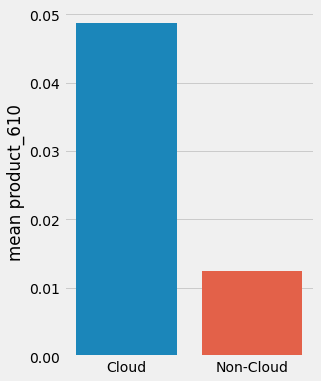

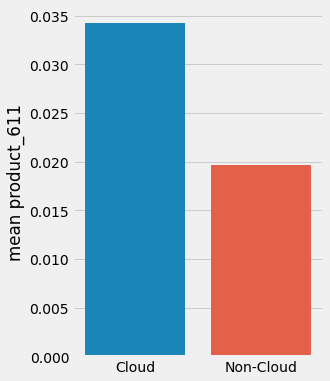

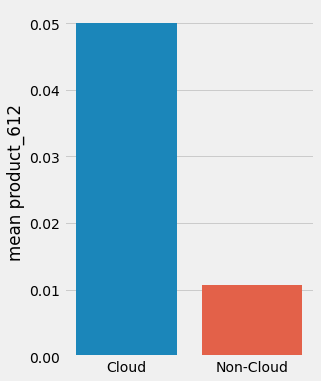

In [64]:
for prod in prod_list:
    plot_bar(us_data, prod, cluster_split=False, aggr='mean')

## Budget and Revenue

#### 1. IT budget total

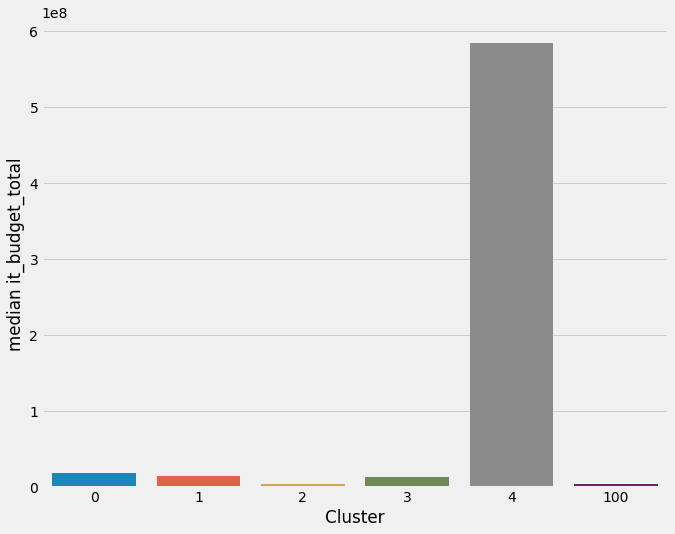

In [65]:
plot_bar(us_data, 'it_budget_total', cluster_list=cluster_list, aggr='median') 

Clearly cluster 4 contains outliers

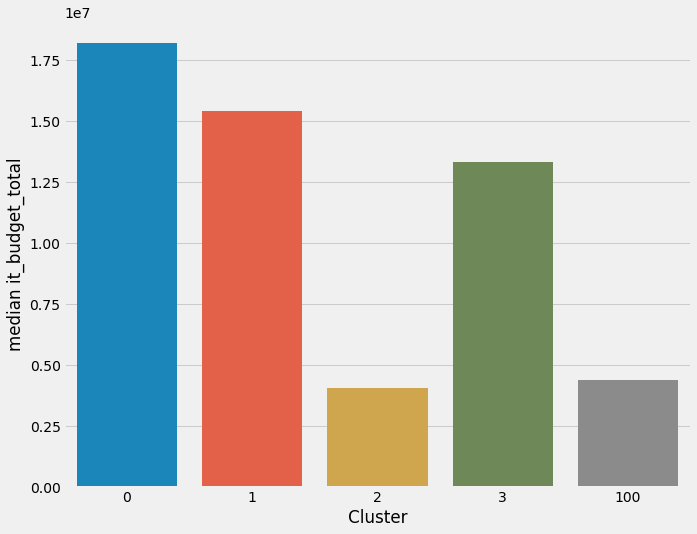

In [66]:
plot_bar(us_data, 'it_budget_total', cluster_list=clusterList_filter, aggr='median')

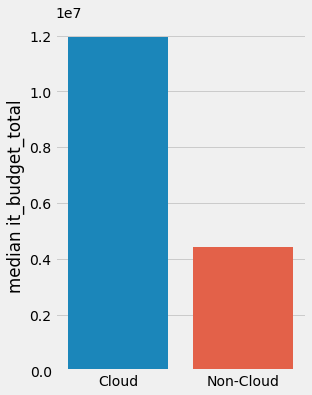

In [67]:
plot_bar(us_data, 'it_budget_total', cluster_split=False, aggr='median')

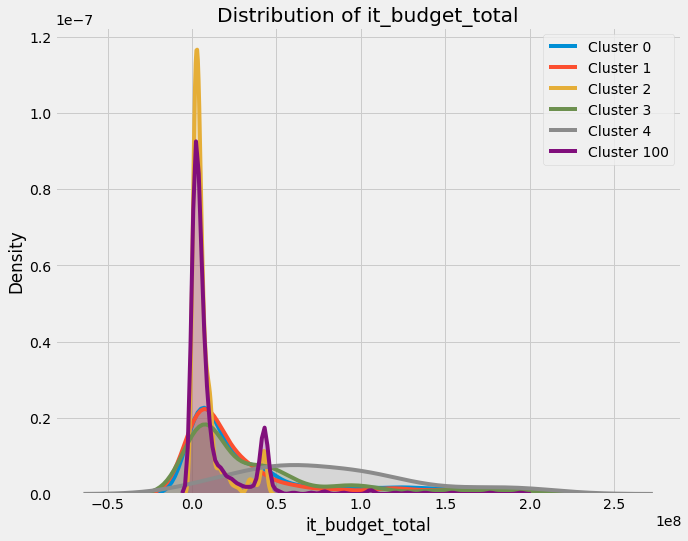

In [68]:
df_filter = us_data[us_data['it_budget_total'] < 200000000]
plot_histogram(df_filter, 'it_budget_total', cluster_list=cluster_list)

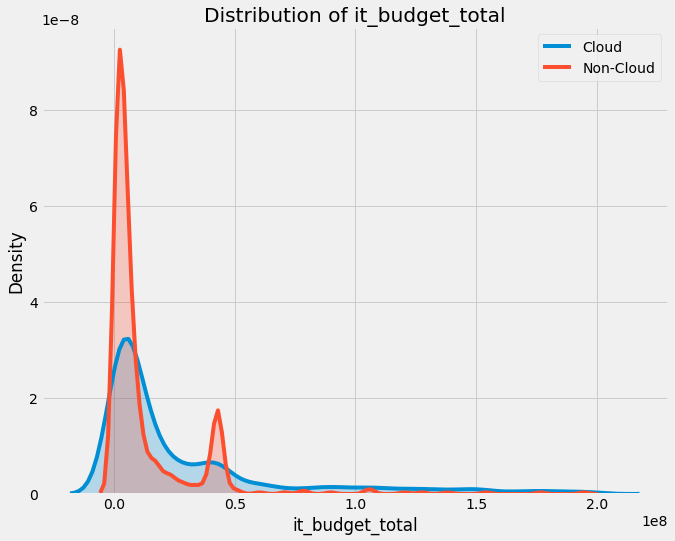

In [69]:
plot_histogram(df_filter, 'it_budget_total', cluster_split=False)

#### 2. External total

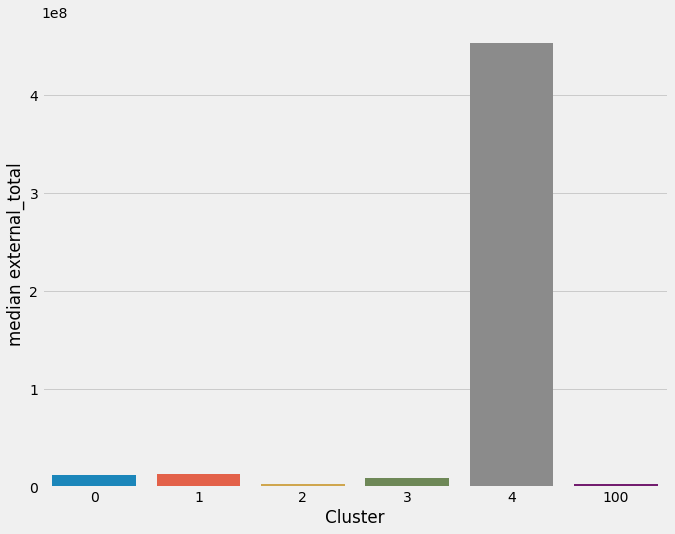

In [70]:
plot_bar(us_data, 'external_total', cluster_list=cluster_list, aggr='median')

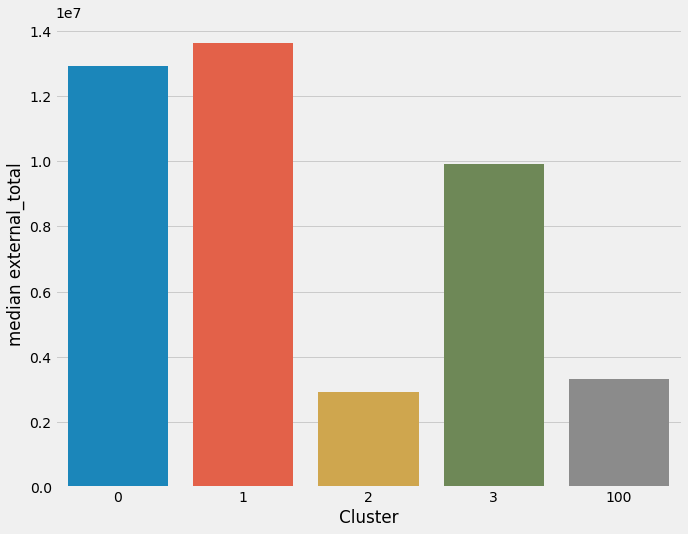

In [71]:
plot_bar(us_data, 'external_total', cluster_list=clusterList_filter, aggr='median')

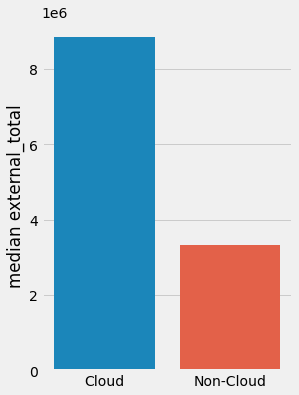

In [72]:
plot_bar(us_data, 'external_total', cluster_split=False, aggr='median')

#### 3. Internal total

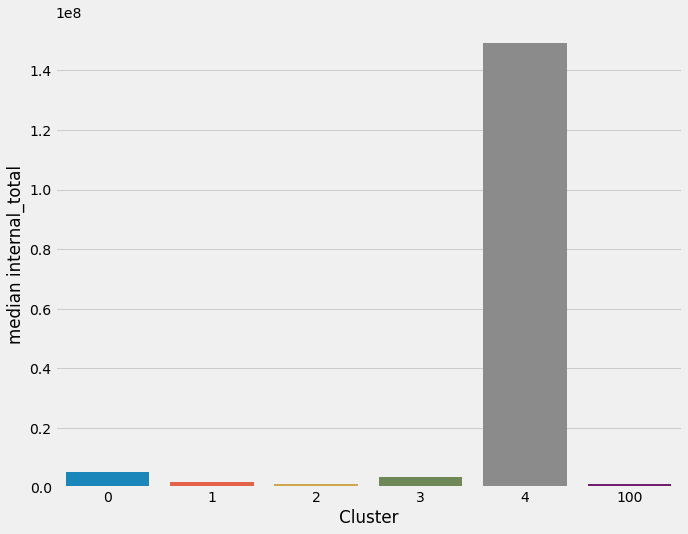

In [73]:
plot_bar(us_data, 'internal_total', cluster_list=cluster_list, aggr='median')

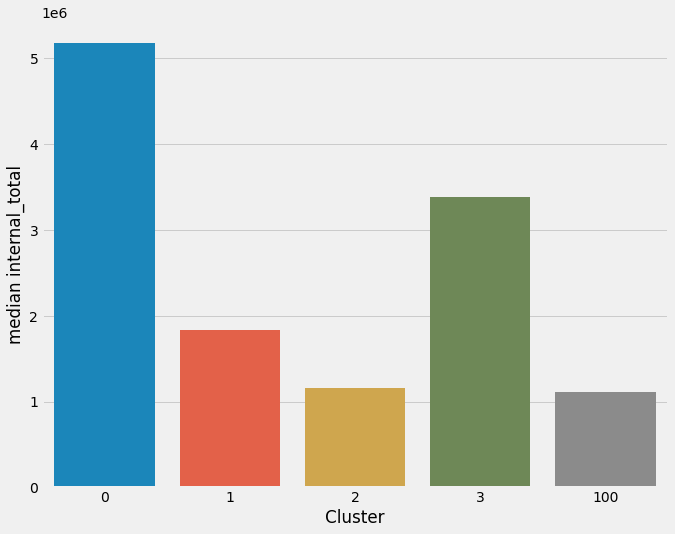

In [74]:
plot_bar(us_data, 'internal_total', cluster_list=clusterList_filter, aggr='median')

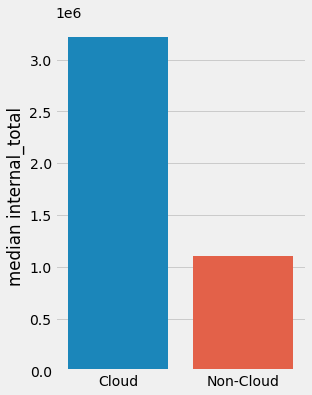

In [75]:
plot_bar(us_data, 'internal_total', cluster_split=False, aggr='median')

#### 4. External vs Internal

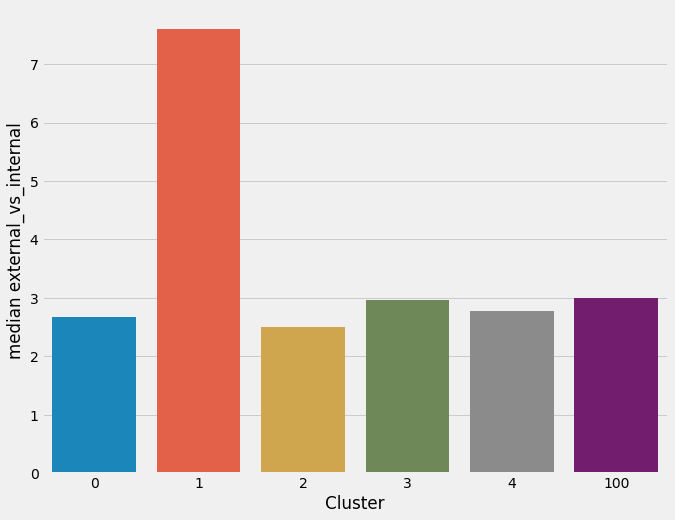

In [76]:
plot_bar(us_data, 'external_vs_internal', cluster_list=cluster_list, aggr='median')

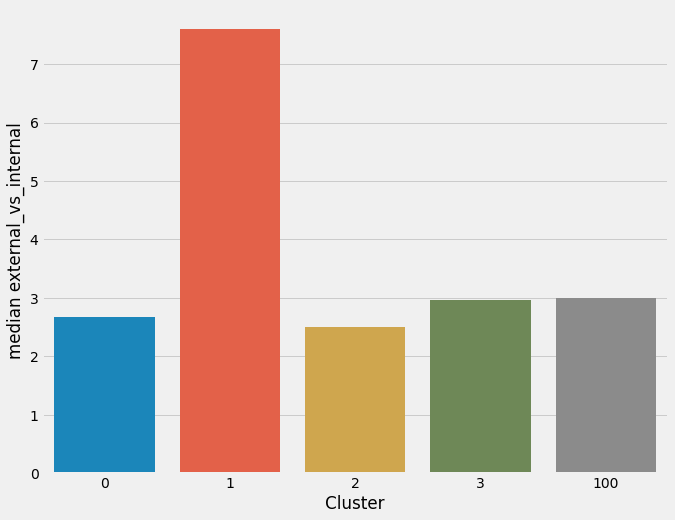

In [77]:
plot_bar(us_data, 'external_vs_internal', cluster_list=clusterList_filter, aggr='median')

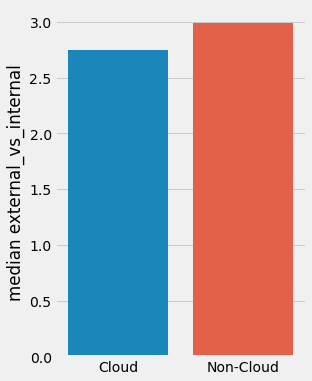

In [78]:
plot_bar(us_data, 'external_vs_internal', cluster_split=False, aggr='median')

#### 5.Revenue per employee

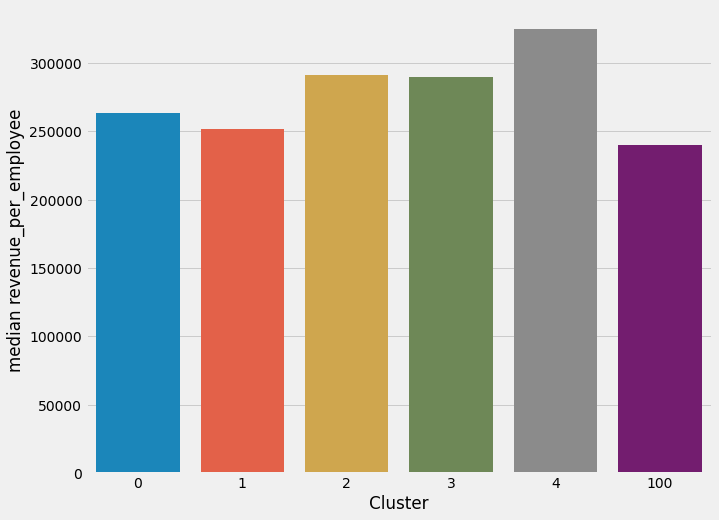

In [79]:
plot_bar(us_data, 'revenue_per_employee', cluster_list=cluster_list, aggr='median')

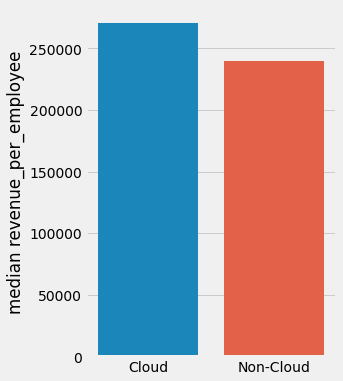

In [80]:
plot_bar(us_data, 'revenue_per_employee', cluster_split=False, aggr='median')

#### 6. Total Revenue

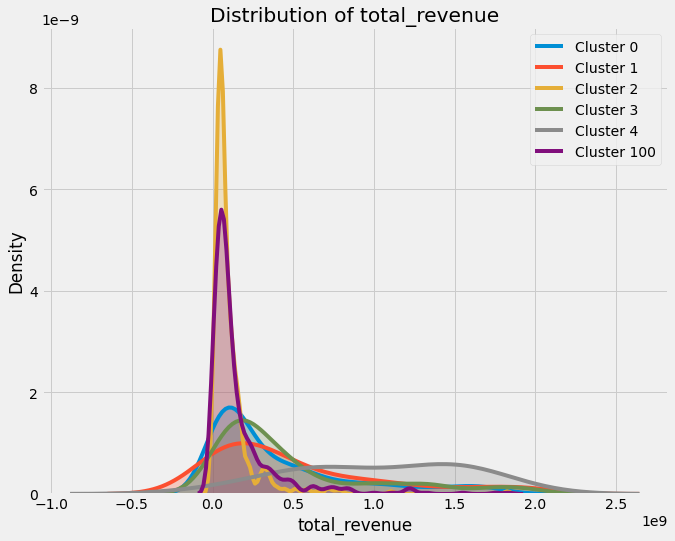

In [81]:
df_filter = us_data[us_data['total_revenue'] < 2000000000]
plot_histogram(df_filter, 'total_revenue', cluster_list)

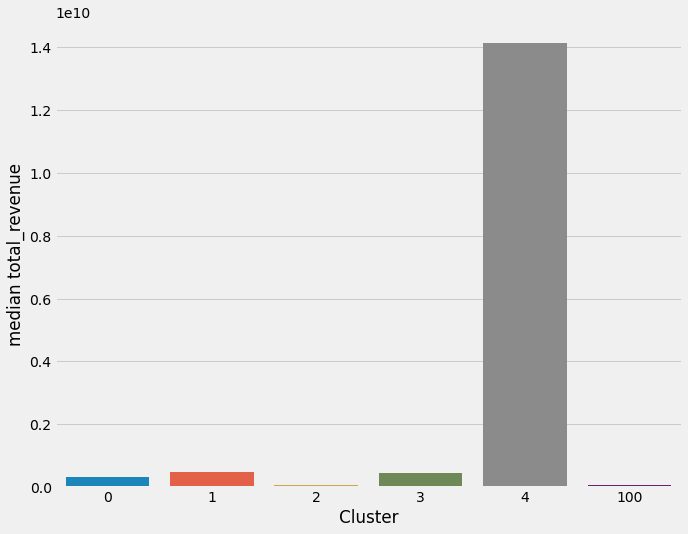

In [82]:
plot_bar(us_data, 'total_revenue', cluster_list=cluster_list, aggr='median')

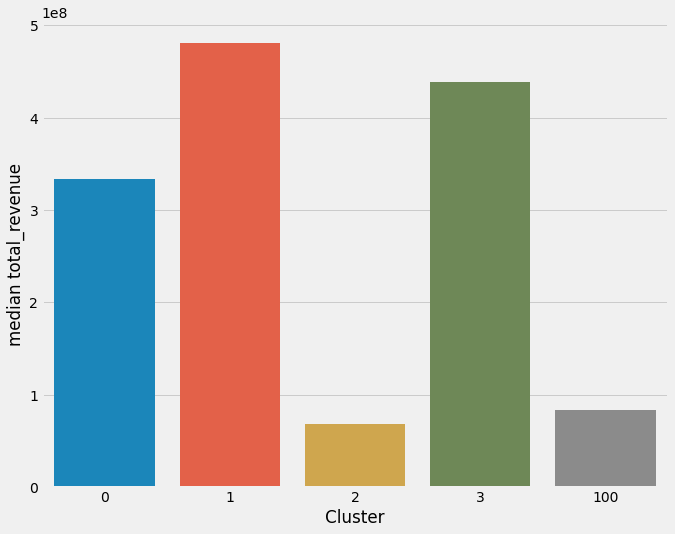

In [83]:
plot_bar(us_data, 'total_revenue', cluster_list=clusterList_filter, aggr='median')

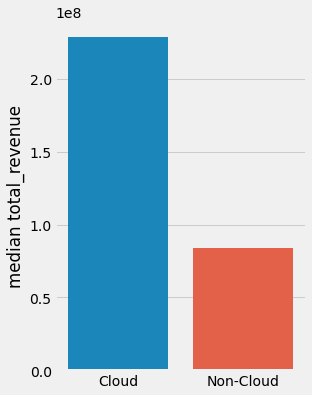

In [84]:
plot_bar(us_data, 'total_revenue', cluster_split=False, aggr='median')

## Industry


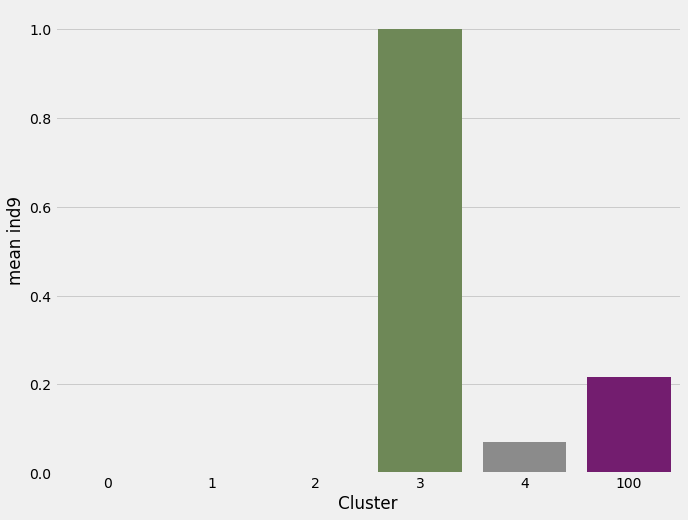

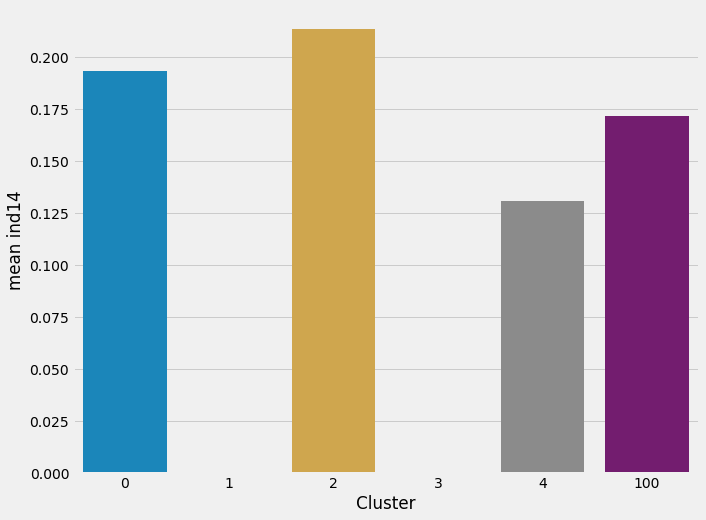

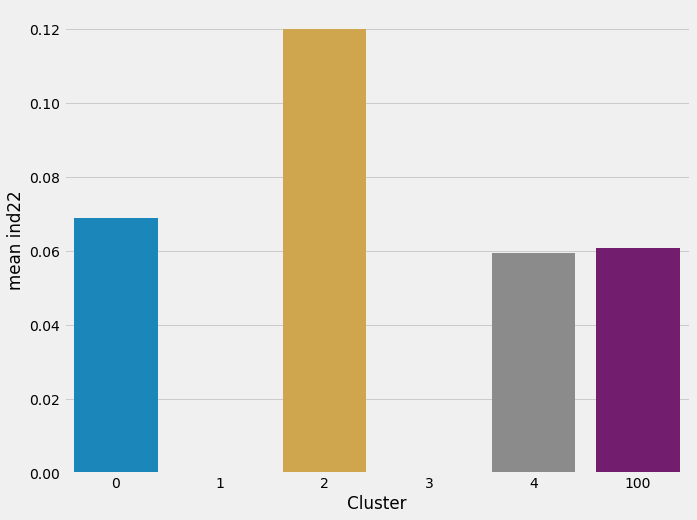

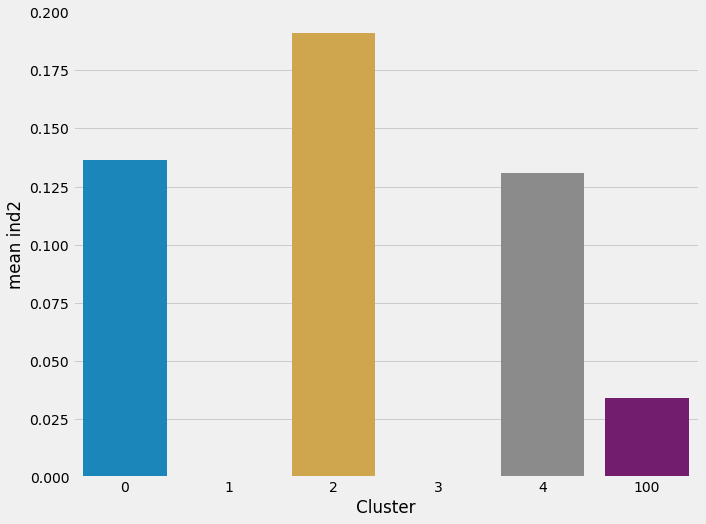

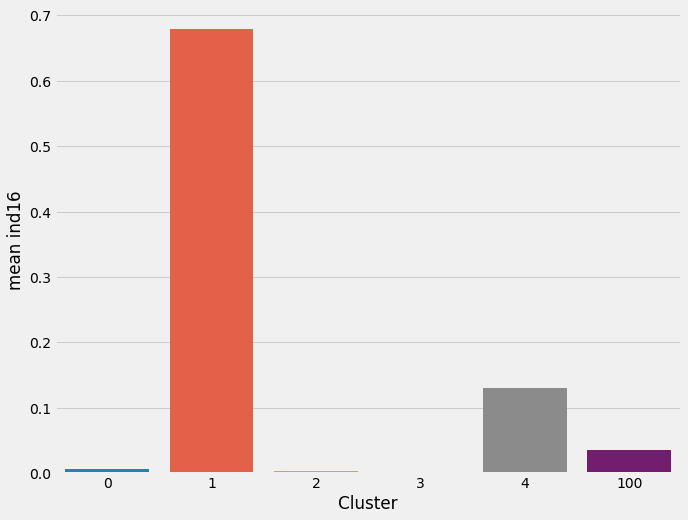

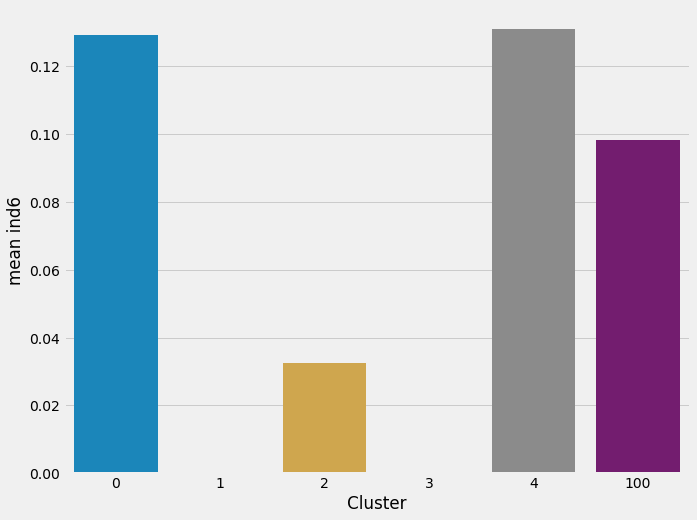

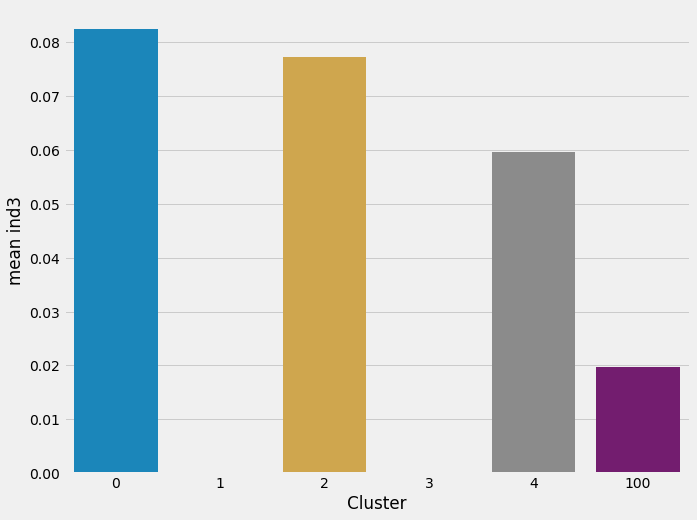

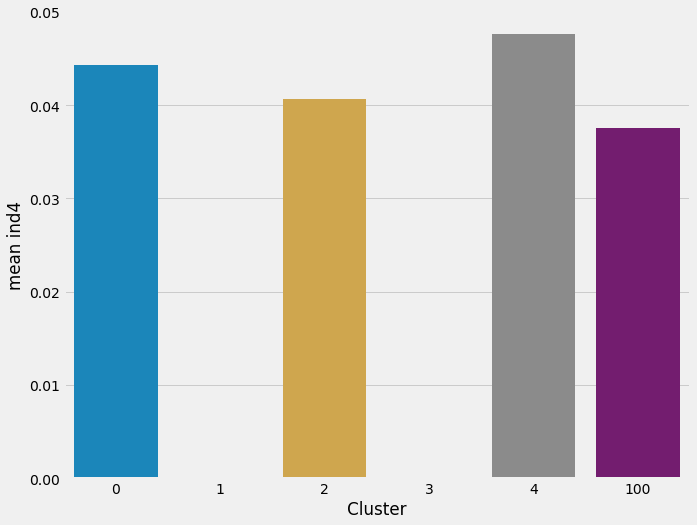

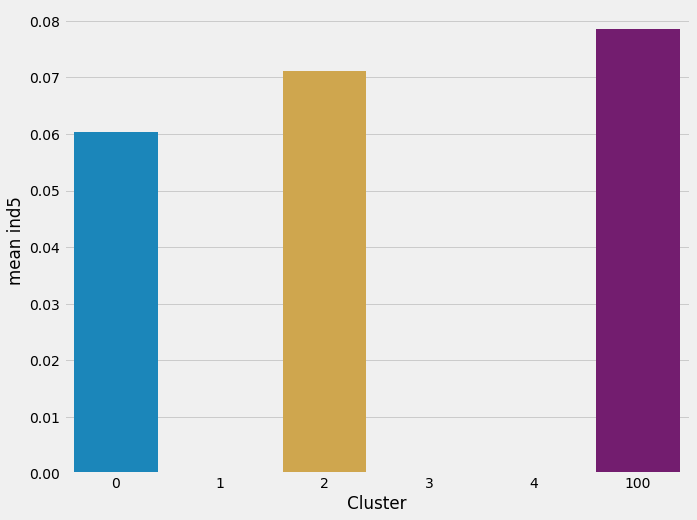

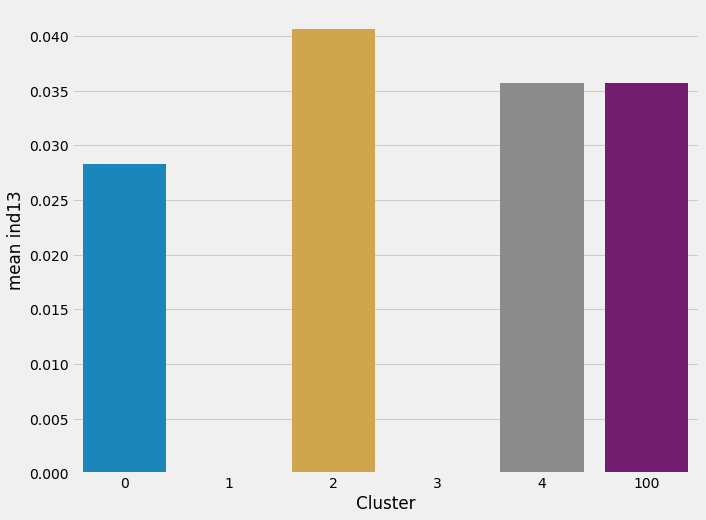

In [86]:
industry_cols = [col for col in us_data if col.startswith('ind')]
for ind in industry_cols:
    plot_bar(us_data, ind, cluster_list, aggr='mean')

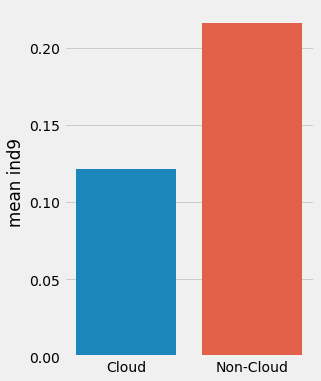

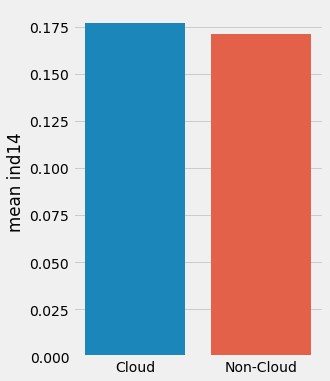

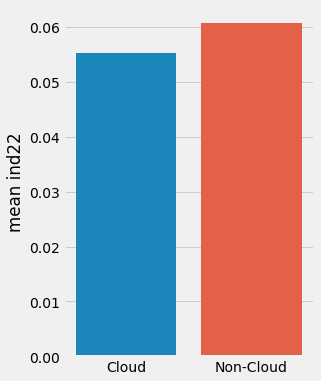

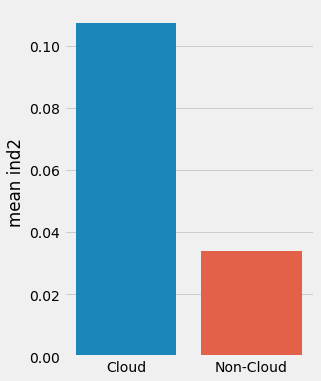

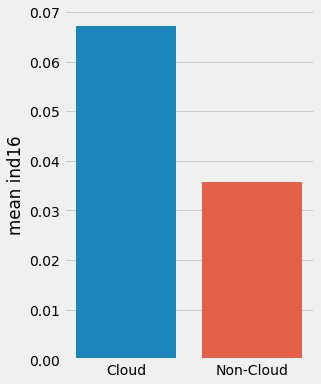

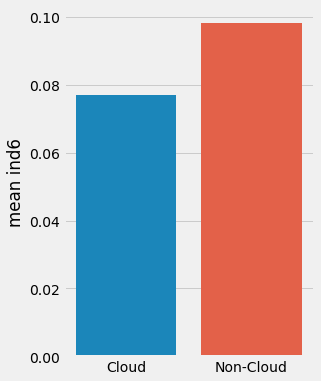

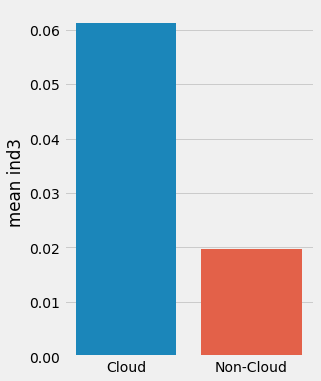

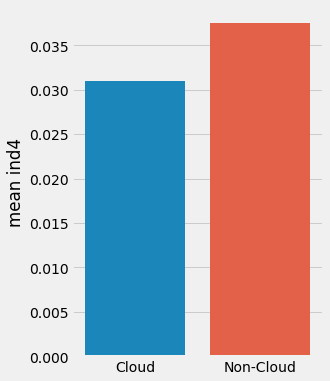

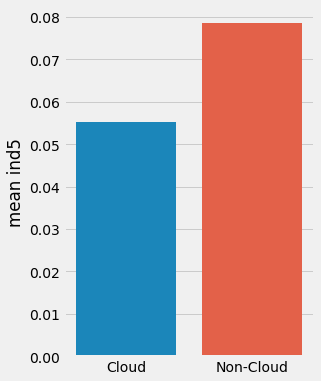

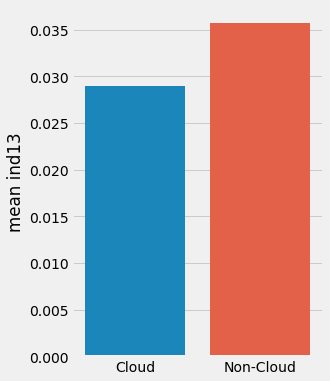

In [88]:
for ind in industry_cols:
    plot_bar(us_data, ind, cluster_split=False, aggr='mean')

Summary of analyses conducted on US companies.The below chart shows the aggregated values for the column name in the index for differet clusters - 0,1,2,3,4. 

###### Cluster 100: Proxy for non-cloud companies
###### Cloud : The aggregation after grouping the companies in clusters 0,1,2,3 and 4. 

In [89]:
chart_analysis = chart.dropna(how='all')
chart_analysis[[0,1,2,3,4,100,'Cloud']] = chart_analysis[[0,1,2,3,4,100,'Cloud']].astype(float).round(2)
chart_analysis

,Aggregation,0,1,2,3,4,100,Cloud
avg_raw_capacity_tb,median,5.439000e+01,4.982000e+01,46.20,4.376000e+01,5.905000e+01,38.85,4.914000e+01
avg_usable_capacity_tb,median,3.533000e+01,3.244000e+01,30.48,2.734000e+01,3.864000e+01,25.01,3.253000e+01
avg_free_capacity_tb,median,1.335000e+01,1.285000e+01,12.02,1.080000e+01,1.401000e+01,9.64,1.229000e+01
avg_used_capacity_tb,median,1.672000e+01,1.579000e+01,13.89,1.389000e+01,1.867000e+01,11.84,1.481000e+01
last_12_months_storage_spend,median,8.452692e+04,7.952704e+04,56107.54,6.366721e+04,5.066046e+05,52054.91,7.897973e+04
product_601,mean,4.600000e-01,4.100000e-01,0.30,3.700000e-01,7.500000e-01,0.22,4.200000e-01
product_602,mean,3.000000e-02,2.000000e-02,0.02,4.000000e-02,8.000000e-02,0.02,3.000000e-02
product_603,mean,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00
product_604,mean,3.900000e-01,3.500000e-01,0.29,3.300000e-01,7.300000e-01,0.26,3.700000e-01
product_605,mean,3.000000e-02,2.000000e-02,0.01,2.000000e-02,1.500000e-01,0.01,3.000000e-02


For any quick comparison of any column values across cllusters, use the chart dataframe

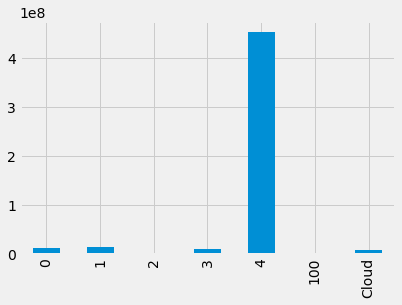

In [90]:
chart_analysis.drop('Aggregation', axis=1).loc['external_total',:].plot(kind='bar')

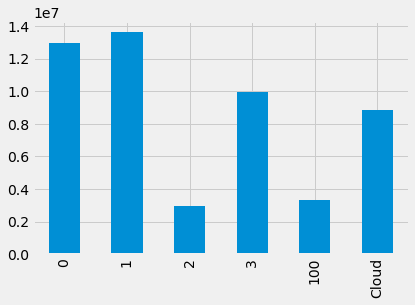

In [91]:
chart_analysis.drop(['Aggregation',4], axis=1).loc['external_total',:].plot(kind='bar')

In [0]:
# Change the location to the file appropriately
chart_analysis.to_csv('/content/drive/My Drive/Colab Notebooks/Capstone/chart_US.csv')